# 3A. PSF modeling and subtraction

> Authors: *Carlos Alberto Gomez Gonzalez* and *Valentin Christiaens*  
> Suitable for VIP *v1.0.3* onwards  
> Last update: *2024/03/25*

**Table of contents**

* [3.1. Loading ADI data](#3.1.-Loading-ADI-data)
* [3.2. median-ADI](#3.2.-median-ADI)
    - [3.2.1. Full-frame median-ADI](#3.2.1.-Full-frame-median-ADI)
    - [3.2.2. Smart median-ADI](#3.2.2.-Smart-median-ADI)
* [3.3. Pairwise frame difference](#3.3.-Pairwise-frame-difference)
* [3.4. Least-squares approximation (LOCI)](#3.4.-Least-squares-approximation-(LOCI))
* [3.5. Principal Component Analysis (PCA)](#3.5.-Principal-Component-Analysis-(PCA))
    - [3.5.1. Full-frame PCA](#3.5.1.-Full-frame-PCA)
    - [3.5.2. Optimizing the number of PCs for full-frame PCA-ADI](#3.5.2.-Optimizing-the-number-of-PCs-for-full-frame-PCA-ADI)
    - [3.5.3. Full-frame  PCA-ADI with a parallactic angle threshold](#3.5.3.-Full-frame-PCA-ADI-with-a-parallactic-angle-threshold)
    - [3.5.4. PCA for big datacubes](#3.5.4.-PCA-for-big-datacubes)
    - [3.5.5. Annular PCA](#3.5.5.-Annular-PCA)
    - [3.5.6. PCA in a single annulus and PCA grid](#3.5.6.-PCA-in-a-single-annulus-and-PCA-grid)
* [3.6. Non-negative Matrix Factorization (NMF)](#3.6.-Non-negative-Matrix-Factorization-(NMF))
    - [3.6.1. Full-frame NMF](#3.6.1.-Full-frame-NMF)
    - [3.6.2. Annular NMF](#3.6.2.-Annular-NMF)
* [3.7. Local Low-rank plus Sparse plus Gaussian-noise decomposition (LLSG)](#3.7.-Local-Low-rank-plus-Sparse-plus-Gaussian-noise-decomposition-(LLSG))
* [3.8. ANgular Differential OptiMal Exoplanet Detection Algorithm (ANDROMEDA)](#3.8.-ANgular-Differential-OptiMal-Exoplanet-Detection-Algorithm-(ANDROMEDA))
* [3.9. Forward-Model Matched Filter (FMMF)](#3.9.-Forward-Model-Matched-Filter-(FMMF))
* [3.10. Patch Covariances (PACO)](#3.10.-Patch-Covariances-(PACO))
* [3.11. Summary mosaic](#3.11.-Summary-mosaic)

This tutorial shows:

- how to load ADI-ready datacubes; 
- how to use the stellar PSF subtraction algorithms implemented in VIP to produce final post-processed images, in which to search for faint companions;
- how to use inverse-problem based algorithms to produce SNR and flux maps.

```{note}
Most PSF subtraction routines in VIP (and some other functions) have been implemented in VIP to allow for **multiprocessing**, in order to optimally harness the power of machines equipped with multiple CPUs. Any function where the `nproc` parameter is available in its call can be run in multi-processing, with the value of `nproc` setting the requested number of CPUs to use. Instead of an integer, one can set `nproc=None` to use half of all available CPUs. For optimal results in multiprocessing, set the following environment parameters in your terminal **BEFORE** launching your Jupyter notebook:

`export MKL_NUM_THREADS=1`

`export NUMEXPR_NUM_THREADS=1`

`export OMP_NUM_THREADS=1`

In the case of PCA, singular value decomposition can also be done on **GPU** by setting `svd_mode` to an appropriate value (see [Sec. 3.5.1.](#3.5.1.-Full-frame-PCA) and docstrings of ``vip_hci.psfsub.pca`` for details).
```

Let's first import a couple of external packages needed in this tutorial:

In [5]:
%matplotlib inline
from hciplot import plot_frames, plot_cubes  # plotting routines
from matplotlib import pyplot as plt
from multiprocessing import cpu_count
import numpy as np
from packaging import version

In [6]:
import sys, platform
print("Python executable:", sys.executable)
print("Python version:", platform.python_version())

Python executable: /Users/bhavanapoli/StellarSight/venv/bin/python
Python version: 3.11.14


In the following box we check that your version of VIP is recent enough.

In [8]:
import vip_hci as vip
vvip = vip.__version__
print("VIP version: ", vvip)
if version.parse(vvip) < version.parse("1.0.3"):
    msg = "Please upgrade your version of VIP"
    msg+= "It should be 1.0.3 or above to run this notebook."
    raise ValueError(msg)

/Users/bhavanapoli/StellarSight/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


VIP version:  2.0.0


## 3.1. Loading ADI data

```{note}  
Although we only showcase ADI-based reductions in this tutorial, most PSF subtraction algorithms in VIP are also compatible with **reference star differential imaging (RDI)**. RDI (or ARDI in case of a combined reference and science image library) is triggered whenever a 3D reference cube of PSF images is provided with the optional parameter ``cube_ref``, be it for PSF subtraction or forward modeling. In all cases, ``cube_ref`` triggers RDI only (i.e., the science cube of images is not used to create the PSF model), except for the ``pca_annular`` and ``nmf_annular`` functions, where providing a reference cube triggers by default ARDI (i.e., using both the reference cube **and** the images of the science cube which match the rotation threshold defined by ``delta_rot``). For RDI-only annular PCA/NMF reductions, one can simply increase the value of ``delta_rot`` to an arbitrarily large value (e.g., 100).
```

In the 'dataset' folder of the `VIP_extras` repository you can find a toy ADI (Angular Differential Imaging) cube and a NACO point spread function (PSF) to demonstrate the capabilities of ``VIP``. This is an L'-band VLT/NACO  dataset of beta Pictoris published in [Absil et al. (2013)](https://ui.adsabs.harvard.edu/abs/2013A%26A...559L..12A/abstract) obtained using the Annular Groove Phase Mask (AGPM) Vortex coronagraph. The sequence has been heavily sub-sampled temporarily to make it smaller. The frames were also cropped to the central 101x101 area. In case you want to plug-in your cube just change the path of the following cells.

More info on this dataset, and on opening and visualizing fits files with VIP in general, is available in Tutorial `1. Quick start`.

Let's load the datacube, associated parallactic angles and non-coronagraphic PSF:

In [10]:
from vip_hci.fits import open_fits
from astropy.utils.data import download_file

url_d = "https://github.com/vortex-exoplanet/VIP_extras/raw/master/datasets"
f1 = download_file("{}/naco_betapic_cube_cen.fits".format(url_d), cache=True)
f2 = download_file("{}/naco_betapic_psf.fits".format(url_d), cache=True)
f3 = download_file("{}/naco_betapic_derot_angles.fits".format(url_d), cache=True)

# alternatively, for local files simply provide their full or relative path. E.g.:
#f1 = '../datasets/naco_betapic_cube_cen.fits'
#f2 = '../datasets/naco_betapic_psf.fits'
#f3 = '../datasets/naco_betapic_derot_angles.fits'

cube = open_fits(f1)
psf = open_fits(f2)
angs = open_fits(f3)

FITS HDU-0 data successfully loaded. Data shape: (61, 101, 101)
FITS HDU-0 data successfully loaded. Data shape: (39, 39)
FITS HDU-0 data successfully loaded. Data shape: (61,)


<font color=orange> **Question 1.1:** When observing a celestial object with a given telecope, what 3 parameters do the values of parallactic angle depend on? </font>

<div class="alert alert-block alert-info"> 
    <b>Note: </b>
<a class="anchor" id="war1"></a>

Different questions are raised throughout the notebooks. Corresponding answers are provided at the end of the respective (sub)sections.
</div>

Let's fit the PSF with a 2D Gaussian to infer the FWHM, the flux in a 1-FWHM size aperture, and get a flux-normalized PSF:

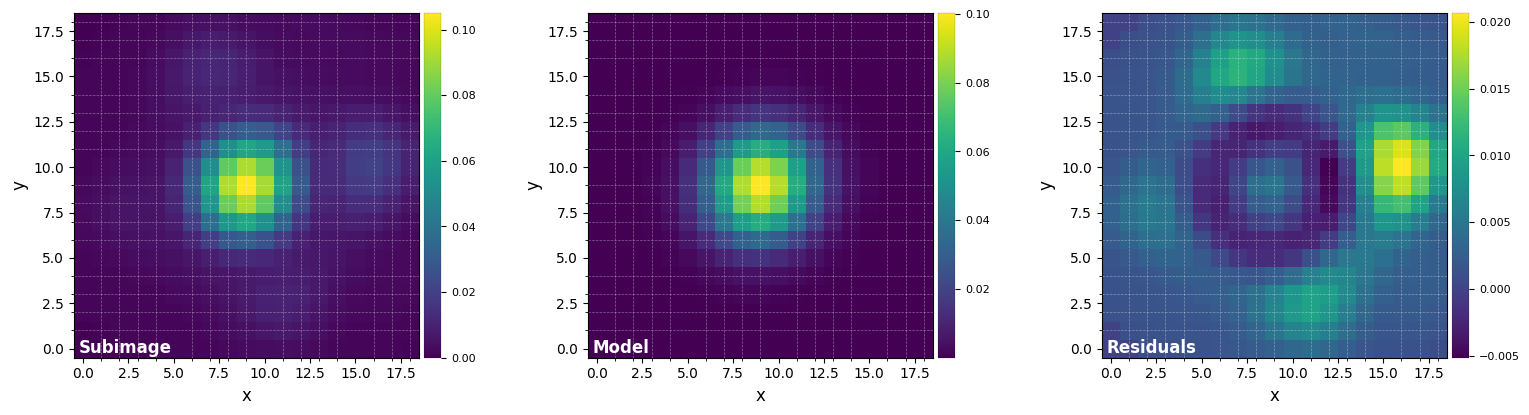

FWHM_y = 4.926059872957138
FWHM_x = 4.675778895005929 

centroid y = 9.010992107833063
centroid x = 9.01917912265807
centroid y subim = 9.010992107833063
centroid x subim = 9.01917912265807 

amplitude = 0.10032285220380603
theta = -38.44618706050392

Mean FWHM: 4.801
Flux in 1xFWHM aperture: 1.307


In [11]:
%matplotlib inline
from vip_hci.fm import normalize_psf
psfn, flux, fwhm_naco = normalize_psf(psf, size=19, debug=True, full_output=True)

In [12]:
print(fwhm_naco)

4.800919383981533


<font color=orange> **Question 3.2:** The FWHM measured above can slightly vary depending on observing conditions and quality of the adaptive optics (AO) correction. In excellent conditions, the PSF gets narrower and can approach the theoretical diffraction limit. What is that angular resolution (in arcsec and in pixels) at L' band ($\lambda \sim$ 3.8µm), for a 8.1m diameter telescope such as the VLT?</font>

<div class="alert alert-block alert-info"> 
    <b>Note: </b>
<a class="anchor" id="war1"></a>
    
The `normalize_psf` function performs internally a fine centering of the PSF. The input PSF should nevertheless already be centered within a few pixel accuracy for the fine centering to work.
</div>

Let's visualize the normalized PSF with `hciplot.plot_frames`. Feel free to adapt the `backend` argument throughout the notebook: `'matplotlib'` (default) allows paper-quality figures with annotations which can be saved (default), while `'bokeh'` enables interactive visualization.

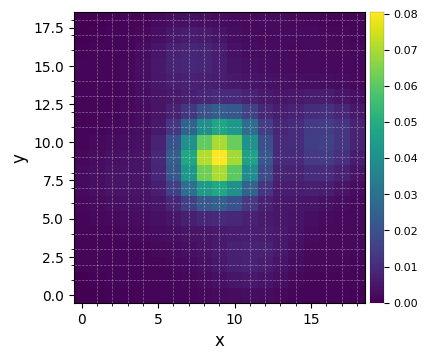

In [13]:
plot_frames(psfn, grid=True, size_factor=4)

Let's finally define the pixel scale for NACO (L' band), which we get from a dictionary stored in the `conf` subpackage:

In [14]:
from vip_hci.config import VLT_NACO
pxscale_naco = VLT_NACO['plsc']
print(pxscale_naco, "arcsec/px")

0.02719 arcsec/px


<font color=orange> **Question 3.3:** When building an instrument, one wants to make sure that even in the best observing conditions the PSF is always sampled at least at the Nyquist frequency - what would then be the coarsest pixel scale that would still allow a Nyquist sampling of the PSF at L' at the VLT? </font>

<font color=green> **Answer 3.1**: The parallactic angle depends on the celestial coordinates of the target, the latitude of the observatory and the observation time (commonly expressed in local hour angle for the target).</font> 

<font color=green> **Answer 3.2**: The theoretical diffraction limit is $\sim \lambda/D$, or $\sim$ 0.10 arcsec after conversion from radian to arcsec. This is $\sim$3.9 pixels at the NACO pixel scale. </font> 

<font color=green> **Answer 3.3**: A maximum pixel scale of 0.05 arcsec/px is required to ensure Nyquist sampling at L' band even in the best observing conditions (i.e. when $\lambda/D$ is equivalent to 2 pixels).</font> 

## 3.2. median-ADI

In the framework of differential imaging techniques, we ultimately rely on modelling and subtracting the stellar PSF and associated speckle noise pattern. Algorithms of different complexities and performances have been proposed since 2006. Several of those algorithms are implemented in ``VIP`` and showcased in the next subsections.

When loading the ADI cube above, we assumed all calibration and preprocessing steps were already performed. In particular, the star is assumed to be already centered in the images. If your data require calibration/preprocessing, feel free to check tutorial `2. Pre-processing` for example uses of VIP preprocessing routines on NACO and SPHERE/IFS data.

**IMPORTANT** - VIP's convention regarding centering is:

- for **odd** number of pixels along the x and y directions: the star is placed on the central pixel;
- for **even** number of pixels: the star is placed on coordinates (dim/2,dim/2) in 0-based indexing.

All ADI-based algorithms involve image rotation. We therefore first set the preferred method to be used for image rotation. This is controlled with the `imlib` and `interpolation` optional arguments (see tutorial `8. FFT- vs. interpolation-based image operations` for more details). Feel free to adapt the following box to test other methods (keeping in mind that FFT-based rotation is only available in versions >= 1.0.0).

In [16]:
imlib = 'vip-fft' #other options: 'opencv', 'skimage'
interpolation=None    #other options: 'lanczos4', 'biquintic' 

### 3.2.1. Full-frame median-ADI

The most simple approach is to model the PSF with the median of the ADI sequence. The median subtraction algorithm is the original post-processing approach proposed for ADI data (see [Marois et al. 2006](https://ui.adsabs.harvard.edu/abs/2006ApJ...641..556M/abstract)):

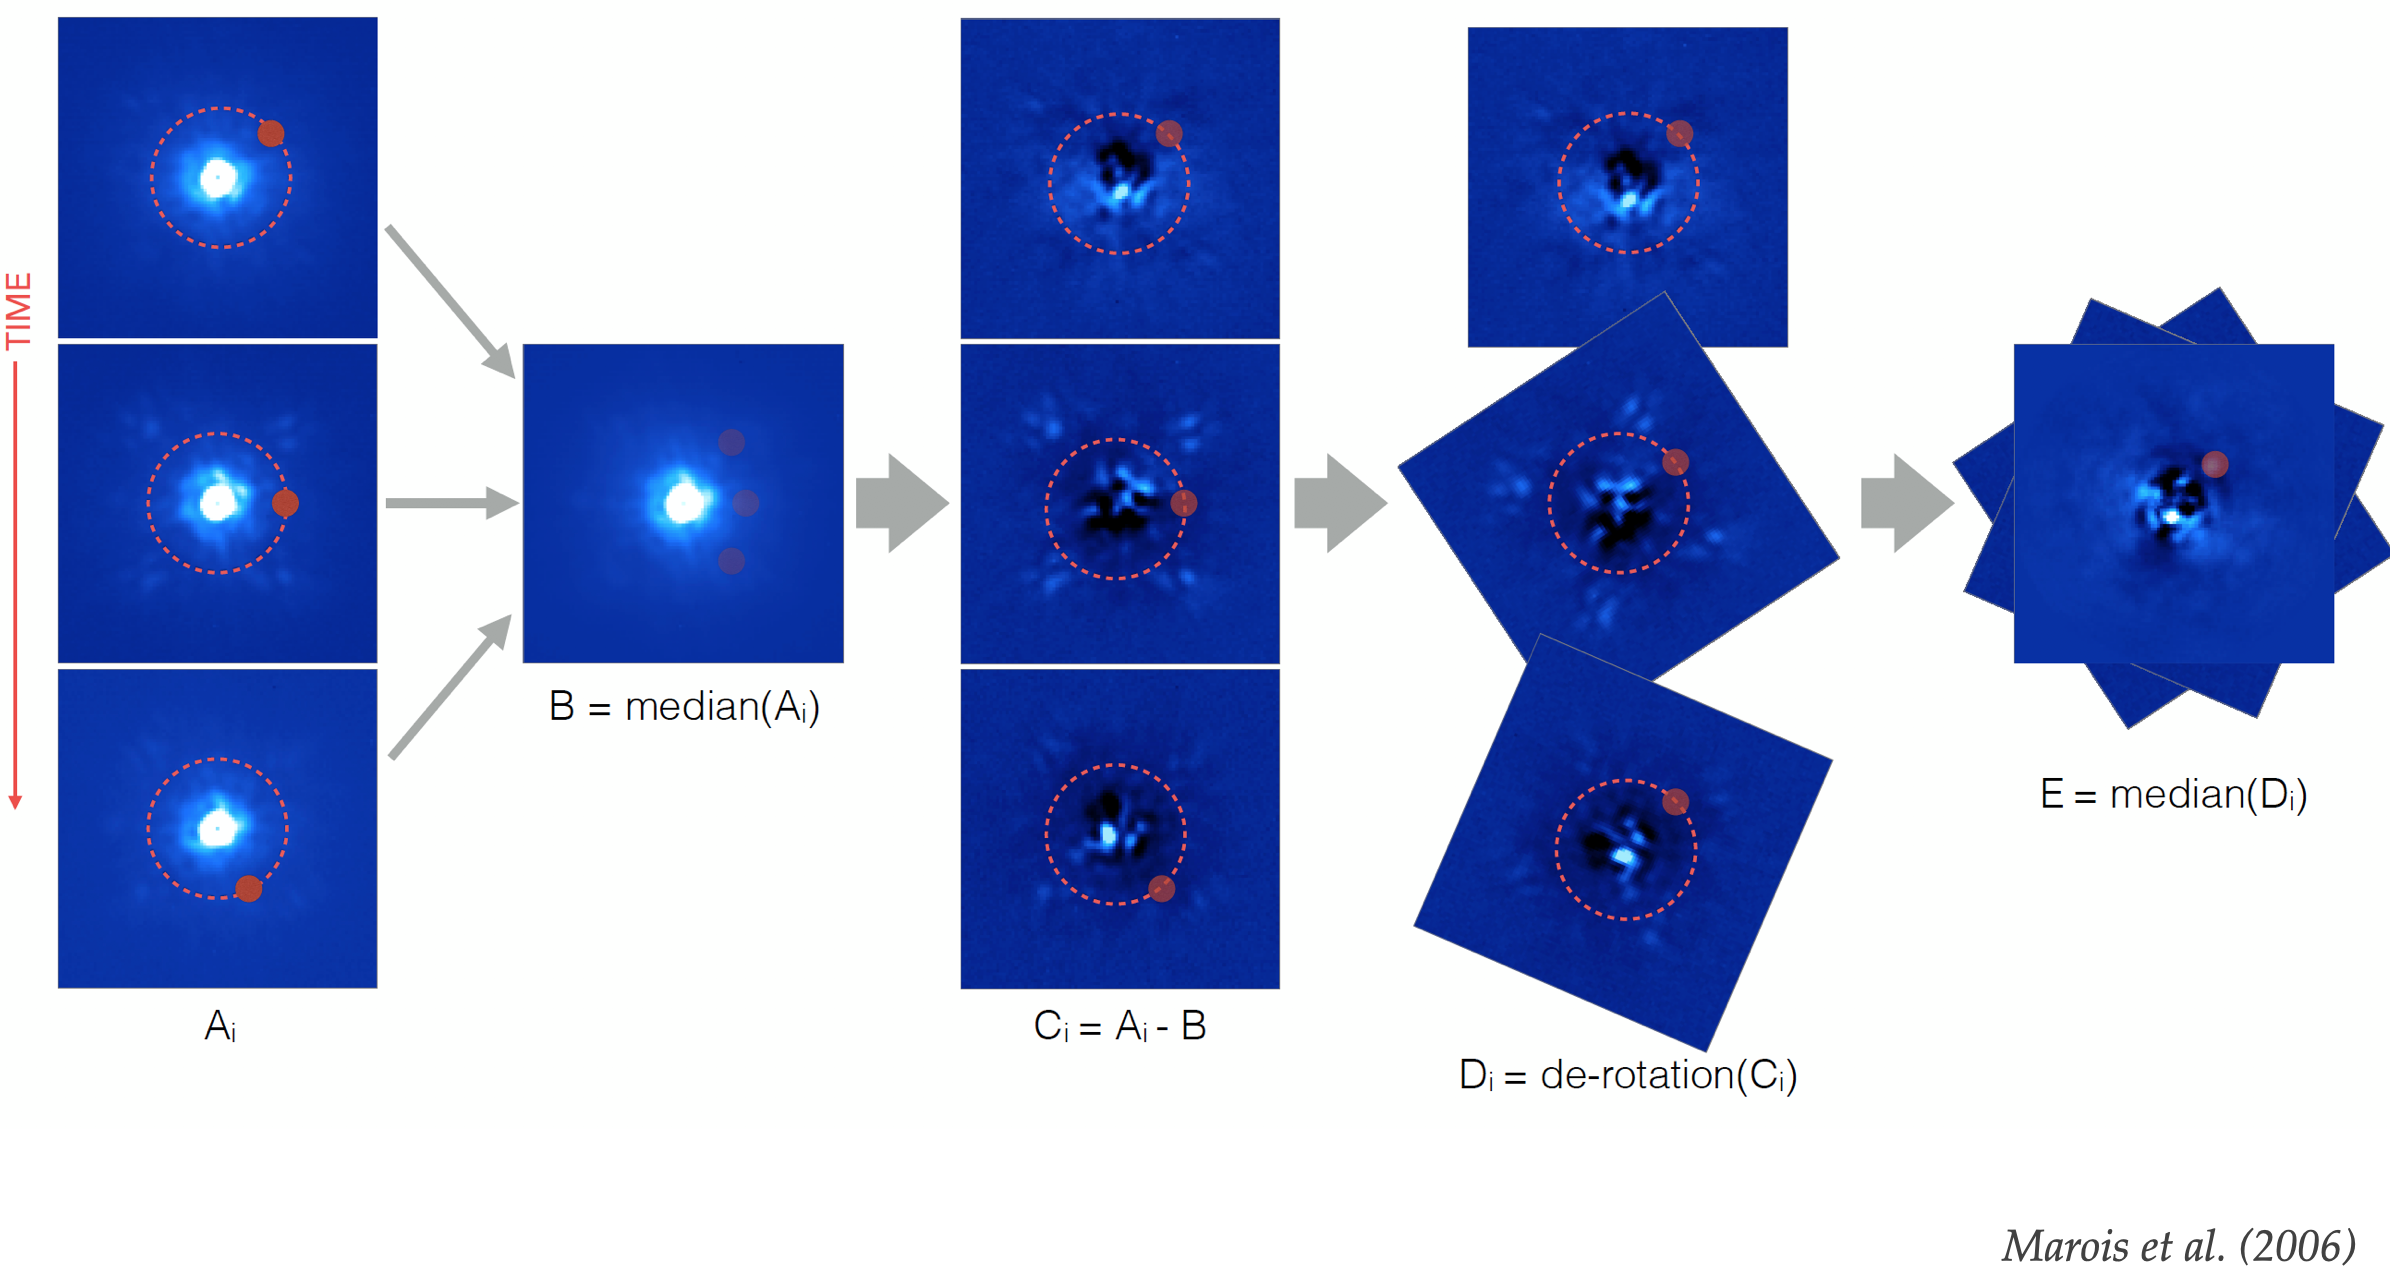

**Figure 3.1** - Median-ADI concept. A sequence of images $A_i$ is obtained in pupil-tracking mode. Any putative planet would rotate throughout the images, along with the field of view, while the stellar halo and speckle pattern remains quasi-static. The median $B_i$ of the sequence does not compare and is subtracted to $A_i$ to create a residual cube $C_i$. The residual cube is derotated ($D_i$) to align the field-of-view. The derotated residual cube is then stacked (typically with a median) to create a finale image $E$.

<font color=orange>**Question 3.4**: In practice, what are the main limitations of median-ADI? </font>

In [17]:
from vip_hci.psfsub import median_sub
fr_adi = median_sub(cube, angs, imlib=imlib, interpolation=interpolation)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-11-26 00:34:30
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:01.626329
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


### 3.2.2. Smart median-ADI

A "smart median-ADI" can be performed in concentric annuli and using a parallactic angle threshold. For each image of the input cube the subtracted model consists of the median of the `nframes` closest images in time that have rotated by at least `delta_rot`x FWHM (linear motion) - i.e. it is a different model PSF for each image. This model is constructed in concentric annuli of width `asize`x FWHM, starting at `radius_int` pixels radius (i.e. the inner `radius_int` pixels are masked).

<font color=orange> **Question 3.5**: What are the pros and cons of using a parallactic angle threshold? </font>

In [18]:
fr_adi_an = median_sub(cube, angs, fwhm=fwhm_naco, asize=fwhm_naco, mode='annular', delta_rot=0.5, 
                       radius_int=4, nframes=4, imlib=imlib, interpolation=interpolation)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-11-26 00:34:37
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 9, FWHM = 4.800919383981533
Optimized median psf reference subtracted
Done derotating and combining
Running time:  0:00:01.654634
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Let's vizualize the final images:

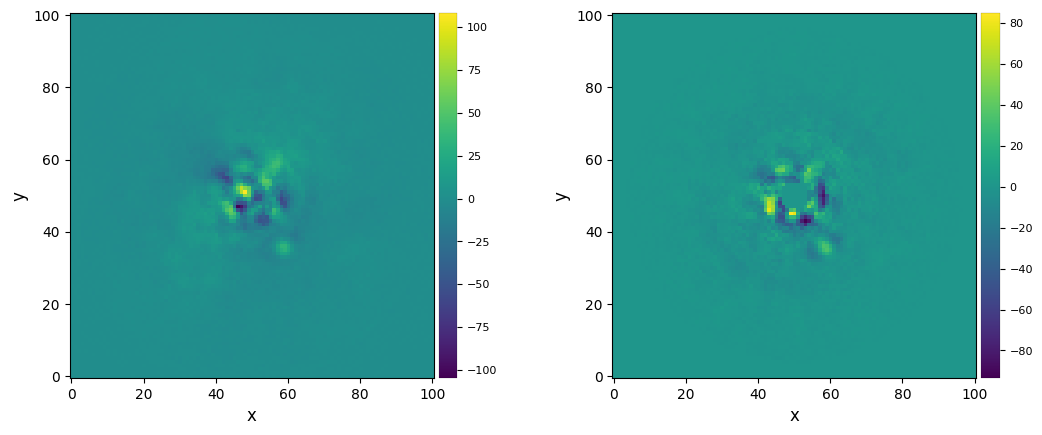

In [19]:
plot_frames((fr_adi, fr_adi_an))

Strong residuals can be seen near the center of the image, with a faint potential point source in the south-west of the final image.

<font color=green> **Answer 3.4** Quasi-static speckles (i.e. not exactly static) are one of the main limitations. These stem from slowly varying aberrations in the instrument and optics while tracking the object during the observation (due e.g. to different mechanical flexures, imperfections in the mirrors, non-common path aberrations in the instrument). If observing conditions are not stable (e.g. sudden bursts in seeing), the adaptive optics performance may also fluctuate during the observing sequence, which can also lead to a changing speckle pattern. The latter can be mitigated with bad frame removal (see tutorial 2).

<font color=green> **Answer 3.5** A non-zero parallactic angle threshold helps minimizing self-subtraction of putative planets, by bulding a model for subtraction using only images where a putative planet has sufficiently rotated. On the other hand, a large parallactic angle threshold can force the use of images taken far away in time from the one considered for modeling. The decorrelation of quasi-static speckle can then lead to a poor PSF model for subraction. A value of `delta_rot=1` will lead to low self-subtraction and is a good default value for observations obtained in *good* and *stable* conditions with *sufficient field rotation*, but keep in mind that the optimal value of `delta_rot` for a specific dataset and given planet radial separation may be different than 1.

## 3.3. Pairwise frame difference

Another simple approach is to perform pairwise frame subtraction, taking into account both a rotation and distance (similarity) threshold.
For this example, we select the L1-distance metric, with a distance threshold set to the 90th percentile of all distances, a 0.5xFWHM linear rotation threshold, an innermost radius starting at 2 px, and an annular size set to `fwhm_naco` pixels.

In [20]:
from vip_hci.psfsub import frame_diff 
fr_fdiff = frame_diff(cube, angs, fwhm_naco, metric='l1', dist_threshold=90, delta_rot=0.5, 
                      radius_int=4, asize=fwhm_naco, nproc=None, imlib=imlib, 
                      interpolation=interpolation, verbose=True)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-11-26 00:34:45
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
9 annuli. Performing pair-wise subtraction:
Ann 1    PA thresh: 21.24    Ann center:   6    N segments: 1 Ann 3    PA thresh:  8.58    Ann center:  16    N segments: 1 Ann 2    PA thresh: 12.23    Ann center:  11    N segments: 1 Ann 4    PA thresh:  6.60    Ann center:  21    N segments: 1 



Ann 5    PA thresh:  5.37    Ann center:  26    N segments: 1 
Ann 6    PA thresh:  4.52    Ann center:  30    N segments: 1 
Ann 7    PA thresh:  3.91    Ann center:  35    N segments: 1 Ann 8    PA thresh:  3.44    Ann center:  40    N segments: 1 

Ann 9    PA thresh:  3.14    Ann center:  44    N segments: 1 
Done processing annuli
Running time:  0:00:08.703077
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――



Let's vizualize the final image:

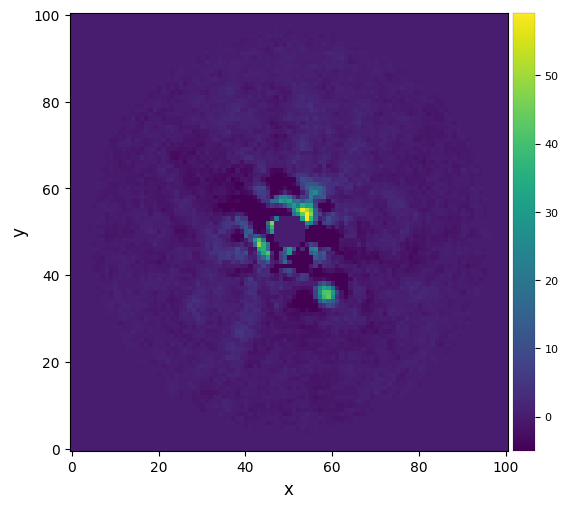

In [21]:
plot_frames(fr_fdiff, vmin=-5)

As for the median-ADI results, there is a potential point-like source towards the south-west, although strong residuals dominate the center of the image.

## 3.4. Least-squares approximation (LOCI)

A continuation of the idea of imposing a rotation/PA threshold was proposed by [Lafreniere et al. (2007)](https://ui.adsabs.harvard.edu/abs/2007ApJ...660..770L/abstract), but this time working in annular patches and using a more sophisticated model PSF. In this case the model PSF is built as a Locally Optimized linear Combination of Images (LOCI; after discarding the ones that have not rotated enough). The coefficients of the linear combination are found to minimize local residuals in each annular subsection (i.e. locally optimized).

In [22]:
from vip_hci.psfsub import xloci
    
fr_lstsq = xloci(cube, angs, fwhm=fwhm_naco, asize=fwhm_naco, n_segments='auto', nproc=1, 
                 metric='correlation', dist_threshold=90, delta_rot=0.1, optim_scale_fact=2,
                 solver='lstsq', tol=0.01, imlib=imlib, interpolation=interpolation)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-11-26 00:35:02
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Building 10 annuli:
Ann 1    PA thresh: 11.42    Ann center:   2    N segments: 2 
Ann 2    PA thresh:  3.82    Ann center:   7    N segments: 3 
Ann 3    PA thresh:  2.29    Ann center:  12    N segments: 5 
Ann 4    PA thresh:  1.64    Ann center:  17    N segments: 7 
Ann 5    PA thresh:  1.27    Ann center:  22    N segments: 9 
Ann 6    PA thresh:  1.04    Ann center:  26    N segments: 11 
Ann 7    PA thresh:  0.88    Ann center:  31    N segments: 12 
Ann 8    PA thresh:  0.76    Ann center:  36    N segments: 14 
Ann 9    PA thresh:  0.67    Ann center:  41    N segments: 16 
Ann 10    PA thresh:  0.62    Ann center:  45    N segments: 18 
Done processing annuli
Running time:  0:00:03.890516
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――



Let's vizualize the final image:

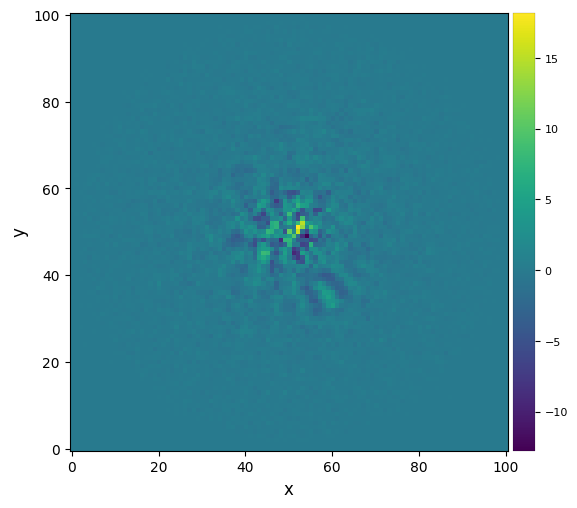

In [23]:
plot_frames(fr_lstsq)

This time the residuals are better subtracted. But the companion candidate also suffers significant self-subtraction. Note as well the comparatively longer processing time.

## 3.5. Principal Component Analysis (PCA)

### 3.5.1. Full-frame PCA

Now let's try the Principal Component Analysis (PCA)-based algorithms ([Amara & Quanz 2012](https://ui.adsabs.harvard.edu/abs/2012MNRAS.427..948A/abstract), [Soummer et al. 2012](https://ui.adsabs.harvard.edu/abs/2012ApJ...755L..28S/abstract)) in `vip.pca`. As a reminder, below is a schematics summarizing how full-frame PCA-ADI works: 

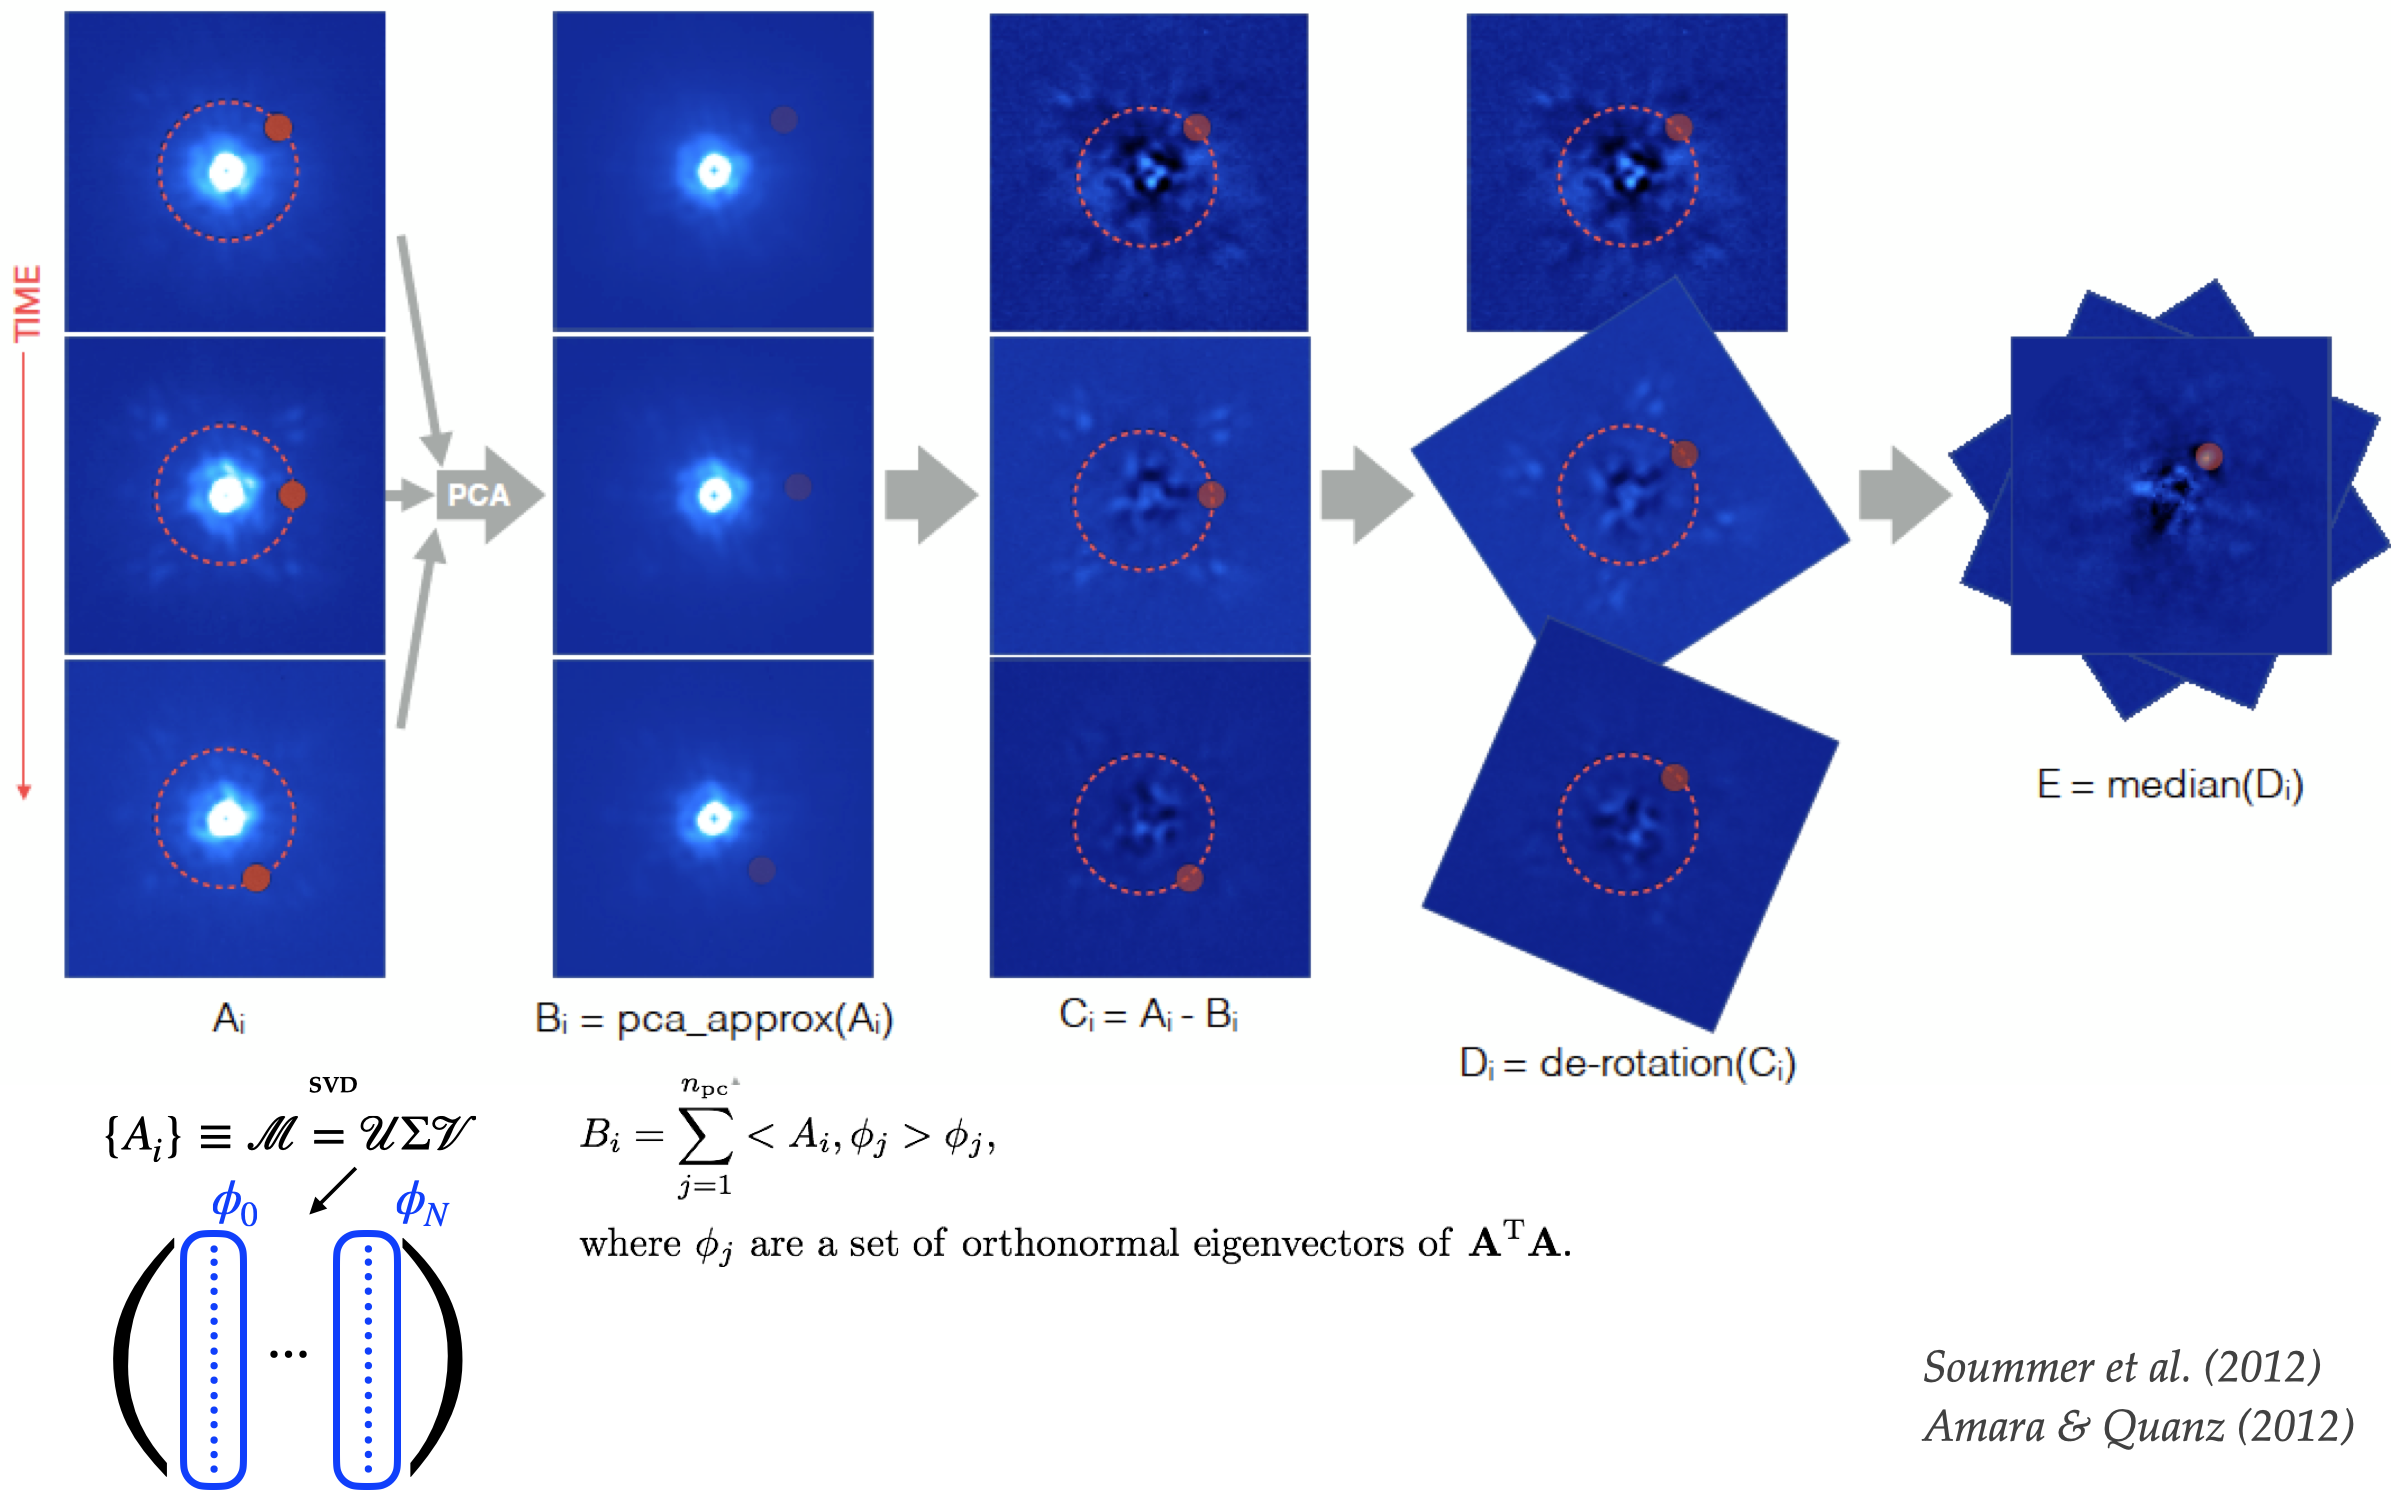

**Figure 3.2** - PCA-ADI concept. Compared to median-ADI (Fig. 3.1), only the model used for subtraction is refined. It is constructed from the projection of each image on the first $n_{\rm pc}$ principal components. The principal components are typically found by singular value decomposition, after converting the observed sequence of images $A_i$ into a 2D matrix (rows: time dimension, columns: linearized version of the images).

Let's set to 5 the number of principal components `ncomp` considered for model creation, and let's run the PCA algorithm (feel free to test other values):

In [24]:
from vip_hci.psfsub import pca
ncomp = 5
fr_pca1 = pca(cube, angs, ncomp=ncomp, mask_center_px=None, imlib=imlib, interpolation=interpolation,
              svd_mode='arpack')

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-11-26 00:35:20
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 17.180 GB
System available memory = 6.560 GB
Done vectorizing the frames. Matrix shape: (61, 10201)
Done SVD/PCA with scipy sparse SVD (ARPACK)
Running time:  0:00:00.009863
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done de-rotating and combining
Running time:  0:00:01.631542
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


The `svd_mode` argument sets how the Singular Value Decomposition, hence the principal components, should be calculated. When not specified, the default mode is 'lapack' (exact SVD calculation by CPU through `numpy`), although other options may get faster results depending on input matrix and your machine (see description of `svd_mode` argument). Calculation by GPU is possible with `svd_mode = 'eigencupy'` (requires CUPY), `svd_mode = 'pytorch'` (requires PYTORCH), or `svd_mode = 'eigenpytorch'` (requires PYTORCH).

Let's visualize the final image. This time let's set the `grid` option on, to better read coordinates from the image:

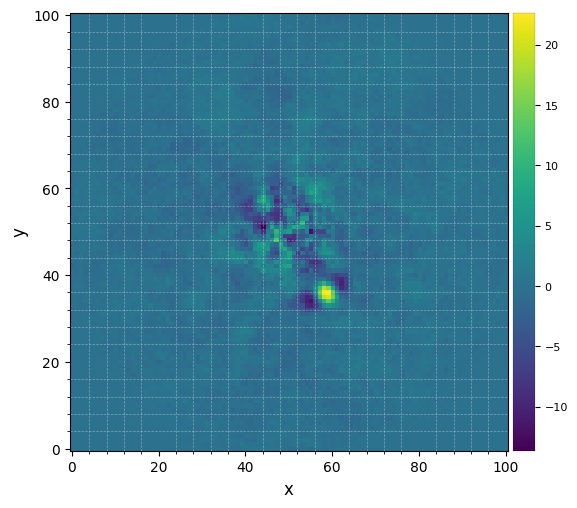

In [25]:
plot_frames(fr_pca1, grid=True)

The improvement is clear compared to previous reductions. Very low residuals are seen near the star, and the companion candidate appears as a bright point source surrounded by negative side-lobes. The procedure is also 15-20x faster than LOCI.

<font color=orange> **Question 3.6**: What is the origin of the negative side lobes? </font>
    
<font color=orange> **Question 3.7**: Are they always expected to be symmetric? </font>

Now let's see whether the candidate is significant. For that let's first set the x,y coordinates of the test point source based on the above image:

In [26]:
xy_b = (58.5, 35.5)

Now let's compute the signal-to-noise ratio at that location, following the definition in [Mawet et al. (2014)](https://ui.adsabs.harvard.edu/abs/2014ApJ...792...97M/abstract).

In [27]:
from vip_hci.metrics import snr
snr1 = snr(fr_pca1, source_xy=xy_b, fwhm=fwhm_naco)
print(r"S/N = {:.1f}".format(snr1))

S/N = 7.7


One can also calculate a S/N ratio map over the whole image (this may take a couple of seconds depending on the size of your image):

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-11-26 00:35:45
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


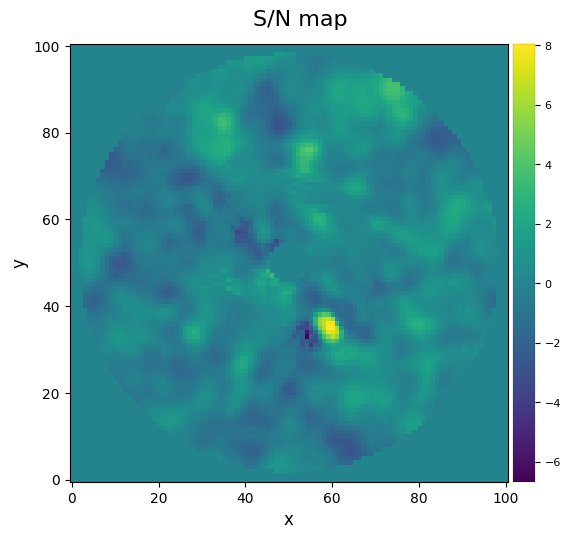

S/N map created using 4 processes
Running time:  0:00:02.154205
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [28]:
from vip_hci.metrics import snrmap
snrmap1 = snrmap(fr_pca1, fwhm_naco, plot=True)

Remember that S/N ratio is NOT the same as significance [Mawet et al. 2014](https://ui.adsabs.harvard.edu/abs/2014ApJ...792...97M/abstract). Let's convert the measured S/N (Students statistics) into a Gaussian "sigma" with equivalent false alarm probability. This first involves calculating the radial separation of the candidate:

In [29]:
from vip_hci.var import frame_center
cy, cx = frame_center(snrmap1)
rad = np.sqrt((cy-xy_b[1])**2+(cx-xy_b[0])**2)

Now let's use the `significance` routine in VIP to operate the conversion:

In [30]:
from vip_hci.metrics import significance
sig1 = significance(snr1, rad, fwhm_naco, student_to_gauss=True)
print(r"{:.1f} sigma detection".format(sig1))

At a separation of 16.8 px (3.5 FWHM), S/N = 7.7 corresponds to a 5.2-sigma detection in terms of Gaussian false alarm probability.
5.2 sigma detection


Congratulations! The detection is significant! You are looking at the giant planet Beta Pic b, one of the most studied directly imaged exoplanets (e.g. [Lagrange et al. 2009](https://ui.adsabs.harvard.edu/abs/2009A%26A...493L..21L/abstract), [Absil et al. 2013](https://ui.adsabs.harvard.edu/abs/2013A%26A...559L..12A/abstract)).

### 3.5.2. Optimizing the number of PCs for full-frame PCA-ADI

Clearly, modeling the background (leaked starlight + static and quasi-static speckles) with PCA leads to better images than subtracting a median frame. We chose 5 principal components (PCs), which greatly reduced the residual noise. A different number of PCs may lead to an even better detection.

One can provide a list of different `ncomp` values to be tested to get an idea of what's present in the data:

In [31]:
fr_pca_list = pca(cube, angs, fwhm=fwhm_naco, mask_center_px=None,
              ncomp=[2, 5, 10, 20, 40], imlib=imlib, interpolation=interpolation)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-11-26 00:35:58
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 17.180 GB
System available memory = 6.492 GB
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.029888
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Computed residual frames for PCs interval: [2, 5, 10, 20, 40]
Number of steps 5
Running time:  0:00:07.056950
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


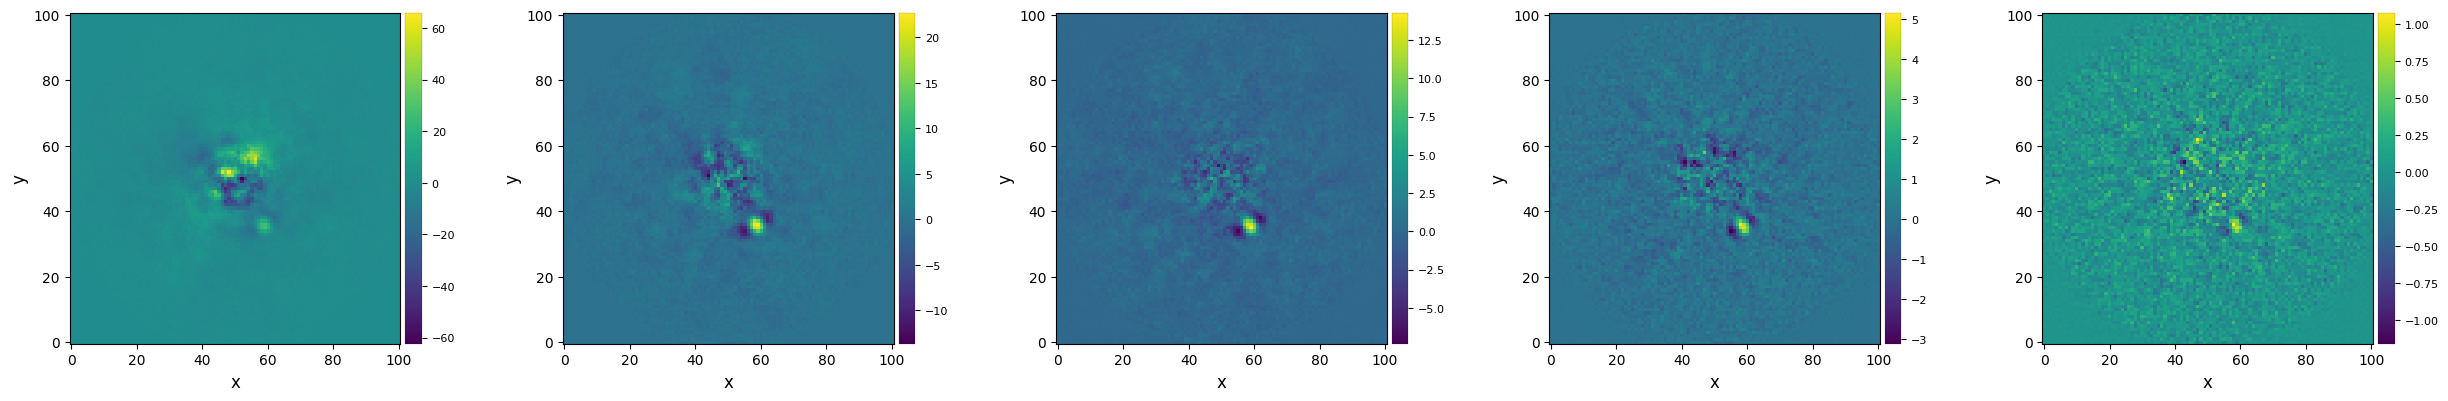

In [32]:
plot_frames(fr_pca_list)

For a given point source in the image, the `pca` function can search for the optimal number of principal components which maximizes the S/N ratio of a given point source. When calling `pca`, this is done by setting `ncomp` to either a list of npc values to be tested, or a tuple of 3 integers (initial value, last value, step) setting the range of explored npc values, and providing the `source_xy` coordinates of the point source of interest:

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-11-26 00:36:11
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 17.180 GB
System available memory = 6.532 GB
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.026205
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Number of steps 26
Optimal number of PCs = 13, for S/N=9.093
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Coords of chosen px (X,Y) = 58.5, 35.5
Flux in a centered 1xFWHM circular aperture = 117.485
Central pixel S/N = 11.308
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Inside a centered 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 9.093
Max S/N (shifting the aperture center) = 12.203
stddev S/N (shifting the aperture center) = 1.975



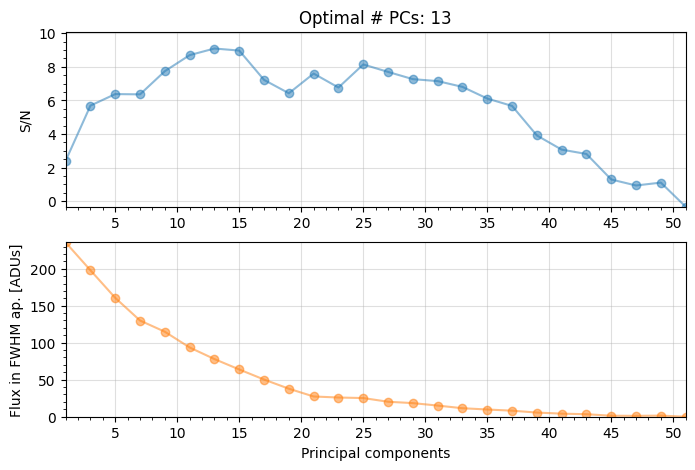

In [33]:
fr_pca2 = pca(cube, angs, fwhm=fwhm_naco, source_xy=xy_b, mask_center_px=None,
              ncomp=(1, 51, 2), imlib=imlib, interpolation=interpolation)

The optimal number of principal components is found to be 13 (note this value may change slightly if using a different imlib/interpolation, but should be in that ballpark).

In [34]:
ncomp_opt=13

<font color=orange> **Question 3.8**: Why is the shape of the S/N vs Principal components curve as seen above (i.e. increasing and then decreasing again)? </font>

Now let's look at the images computed using 5 PCs and 13 PCs (optimal npc found above), and compute the S/N maps:

In [35]:
snrmap1 = snrmap(fr_pca1, fwhm_naco, plot=False)
snrmap2 = snrmap(fr_pca2, fwhm_naco, plot=False)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-11-26 00:36:59
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
S/N map created using 4 processes
Running time:  0:00:02.191591
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-11-26 00:37:01
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
S/N map created using 4 processes
Running time:  0:00:02.058598
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


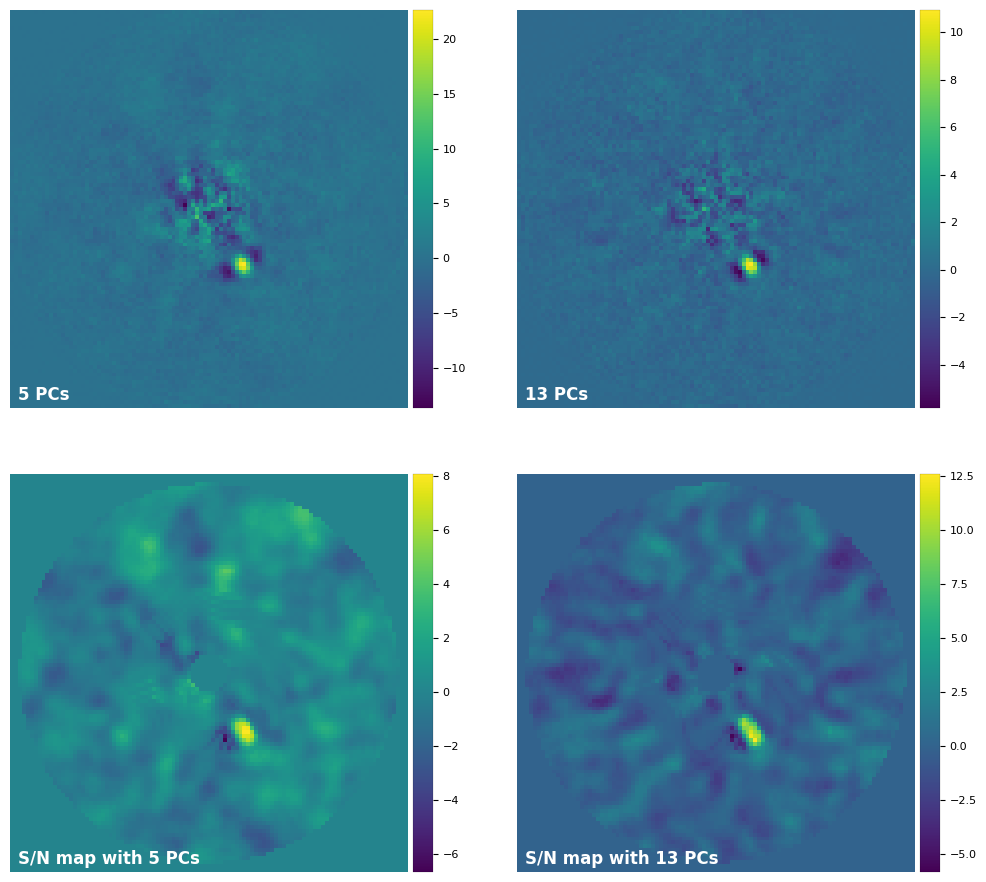

In [36]:
plot_frames((fr_pca1, fr_pca2, snrmap1, snrmap2), rows=2, dpi=100, colorbar=True, axis=False, 
            versp=0.01, horsp=0.2,
            label=('{} PCs'.format(ncomp), '{} PCs'.format(ncomp_opt), 
                   'S/N map with {} PCs'.format(ncomp), 'S/N map with {} PCs'.format(ncomp_opt)), 
            label_pad=8)

With 13 PCs we've increased the S/N of the point source (although the recovered flux is smaller). Let's compare the difference it makes on the significance:

In [37]:
snr2 = snr(fr_pca2, source_xy=xy_b, fwhm=fwhm_naco)
sig2 = significance(snr2, rad, fwhm_naco, student_to_gauss=True)

print(r"S/N = {:.1f} ({} PCs) VS. S/N = {:.1f} ({} PCs)".format(snr1, ncomp, snr2, ncomp_opt))
print(r"{:.1f} sigma detection ({} PCs) VS. {:.1f} sigma detection ({} PCs)".format(sig1, ncomp, sig2, ncomp_opt))

At a separation of 16.8 px (3.5 FWHM), S/N = 11.3 corresponds to a 6.3-sigma detection in terms of Gaussian false alarm probability.
S/N = 7.7 (5 PCs) VS. S/N = 11.3 (13 PCs)
5.2 sigma detection (5 PCs) VS. 6.3 sigma detection (13 PCs)


<font color='orange'> **Question 3.9**: The result above was obtained for the full-frame PCA algorithm. For a given point source (i.e. at a given radius), is the optimal npc expected to be the same for PCA applied in a single annulus (encompassing the point source) and PCA on full frame? If not, would you intuitively expect it to be lower or higher for PCA on a single annulus? </font> 

The answer to Q5.6 will come in [Section 3.5.6](#3.5.6.-PCA-in-a-single-annulus-and-PCA-grid).

<font color=green> **Answer 3.6**: The negative side lobes stem from the presence of the point source in the constructed model used for subtraction. Since the field of view is rotating, the point source will span a range of position angles, and the stellar halo model built for subtraction for each frame of the cube (step B) will typically include some signal from the rotating point-source. </font>
    
<font color=green> **Answer 3.7**: The negative side lobes are not *necessarily* symmetric, as the field rotation rate (hence the rate at which the point source rotates) varies during the observation. The parallactic angle variation is the fastest when the target crosses the meridian. That being said, well-designed ADI observations typically aim for maximal field rotation, which is the case for an observation that is centered around meridian crossing, hence typically resulting in relatively symmetric negative signatures. </font>

<font color=green> **Answer 3.8**: The S/N first increases with $n_{\rm pc}$ due to a better modeling of the speckle pattern by including more PCs. After reaching the optimal $n_{\rm pc}$, the planet self-subtraction starts to dominate (i.e. a large $n_{\rm pc}$ will systematically lead to overfitting of the stellar PSF). </font>

### 3.5.3. Full-frame PCA-ADI with a parallactic angle threshold

We can partially avoid the companion self-subtraction with full-frame PCA by applying a PA threshold for a given distance from the center. This is more efficient if a lot of rotation is present in the data.

This dataset happens to have a good range of rotation (about ~80 deg), and is therefore suitable for that:

Text(0, 0.5, 'Derotation angles')

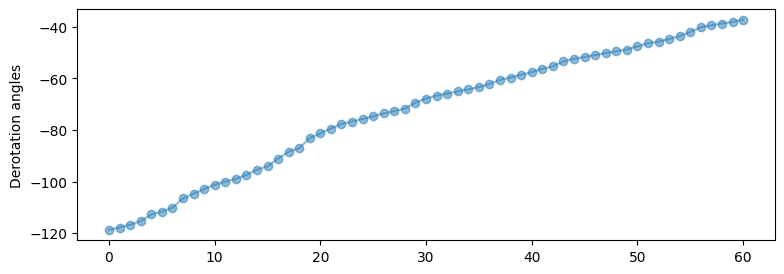

In [38]:
plt.figure(figsize=(9,3))
plt.plot(angs, 'o-', alpha=0.5)
plt.ylabel('Derotation angles')

<font color=orange> **Question 3.10** For a given observatory, where are the most ideal targets (in terms of celestial coordinates) to apply the ADI strategy (i.e. the ones leading to an optimal parallactic angle variation)? </font>

The `pca` function in ``VIP`` accepts a parameter `source_xy` for defining a location of interest for which the rotation threshold will be applied. The parameter `delta_rot` sets the minimum amount of linear motion in terms of the FWHM to include other frames when building the PCA library for each image of the sequence. In the following example we set the threshold to 1 FWHM, which will significantly reduce companion self-subtraction. We also increase the npc to 25.

In [39]:
fr_pca_optlib = pca(cube, angs, ncomp=25, source_xy=xy_b, delta_rot=1, fwhm=fwhm_naco,
                    imlib=imlib, interpolation=interpolation)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-11-26 00:41:27
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 17.180 GB
System available memory = 6.266 GB
Size LIB: min=29.0 / 1st QU=33.0 / med=38.0 / 3rd QU=43.0 / max=51.0
Done de-rotating and combining
Running time:  0:00:02.186430
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


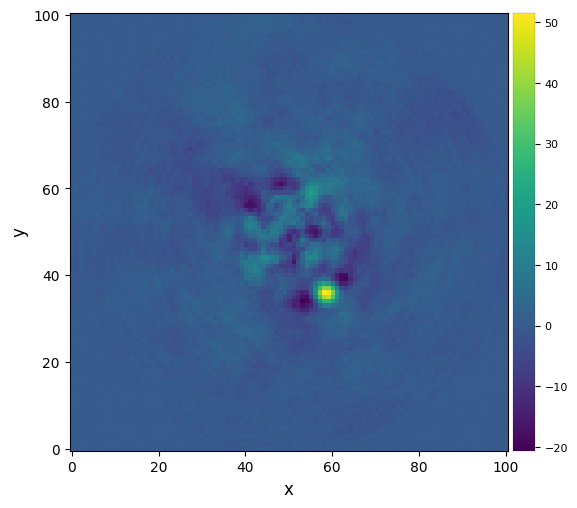

In [40]:
plot_frames(fr_pca_optlib)#, backend='bokeh')

<font color=orange> **Question 3.11**: As can be seen above, a PA threshold reduces the self-subtraction (notice the maximum in the scale), but also leads to a less efficient modeling and subtraction of speckle in the innermost part of the image. 
Why is that so?</font>

We can have a quick report on the last two frames, obtained without and with parallactic angle threshold, and in particular inspect the effect on the flux and S/N ratio of the companion:

In [42]:
snr(fr_pca2, xy_b, fwhm_naco, verbose=True)

S/N for the given pixel = 11.308
Integrated flux in FWHM test aperture = 117.485
Mean of background apertures integrated fluxes = -4.798
Std-dev of background apertures integrated fluxes = 10.553


np.float64(11.308156167113879)

In [43]:
snr(fr_pca_optlib, xy_b, fwhm_naco, verbose=True)

S/N for the given pixel = 7.123
Integrated flux in FWHM test aperture = 561.782
Mean of background apertures integrated fluxes = -25.895
Std-dev of background apertures integrated fluxes = 80.519


np.float64(7.122667419979875)

The companion flux on ``fr_pca_optlib`` is much larger than on ``fr_pca2`` (best full-frame PCA frame without the application of a rotation threshold) because we've reduced self-subtraction (companion over subtraction). On the other hand, the S/N has decreased due to the larger residual speckle noise.

<font color=green> **Answer 3.10** Targets with a declination $\delta$ very different to the latitude $L$ of the observatory will have a very slow parallactic angle variation rate, and are hence not ideal for ADI. On the other extreme, an object whose $\delta$ matches almost exactly $L$ (within a few degrees) will have all the field rotation happening in a matter of minutes, around the time when the object crosses the local meridian (north-south imaginary line) - called transit. This is not ideal either. The best targets for ADI are thus the ones where $|\delta-L|$ is neither too small ($>5$deg) nor too large ($\lesssim 35$deg), as is the case for beta Pic as observed from the Very Large Telescope ($|\delta-L| \approx 27$deg) </font>

<font color=green> **Answer 3.11** Using a PA threshold implies that for a given image to be modeled, the PCA library will be built using exclusively images taken sufficiently far away in time (hence with less correlated speckle). This in turn can lead to a less efficient speckle subtraction. This effect can be particularly stronger in the innermost parts of the image, where a given threshold in terms of linear motion implies a larger delay than for the outer parts of the image. </font>

### 3.5.4. PCA for big datacubes

Computing the PCA model can be a CPU and memory intensive procedure, when working with thousands of large frames, let's say cubes with shapes [10000, 600, 600]. Such cube won't fit on the memory of a normal laptop or desktop computer. With ``VIP`` we just need to provide a positive integer value to the ``batch`` parameter of the ``pca`` function to alleviate this issue. Let's compute the incremental PCA on our toy cube (even if its size does not require it):

In [44]:
fr_increm = pca(cube, angs, ncomp=19, fwhm=fwhm_naco, batch=31, imlib=imlib, interpolation=interpolation)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-11-26 00:42:02
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 17.180 GB
System available memory = 6.247 GB
Cube size = 0.002 GB (61 frames)
Batch size = 31 frames (0.001 GB)

Batch 1/2	shape: (31, 101, 101)	size: 1.3 MB
Batch 2/2	shape: (30, 101, 101)	size: 1.2 MB
Running time:  0:00:00.040015
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Reconstructing and obtaining residuals
Running time:  0:00:01.462899
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


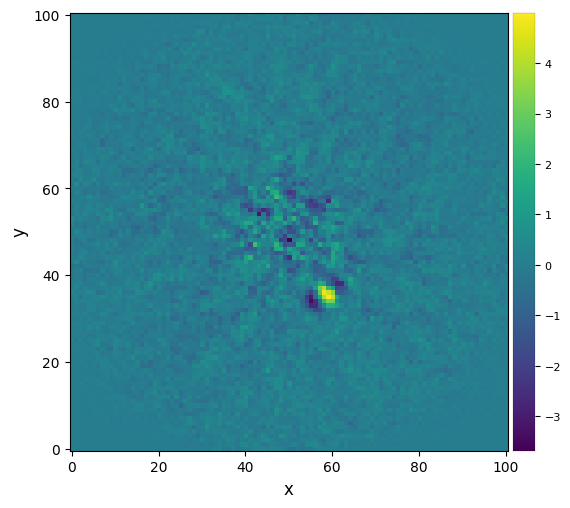

In [45]:
plot_frames(fr_increm)

### 3.5.5. Annular PCA

PCA can also be performed on concentric annuli, and including a parallactic angle threshold when building the PCA library associated to each image. This is the same idea used before in full-frame when the position of a source of interest was defined except that the PA threshold here will be adjusted depending on the radial distance of each annulus from the star. PCA can be computed in full annuli or in separate annular segments (``n_segments``). The computational cost increases accordingly.

The function `pca_annular` processes the cube in annular fashion in a serial or parallel way. Setting `nproc` to an integer will use that number of CPUs in multiprocessing, while setting it to `None` will automatically set it to half the number of CPUs available on the machine. The improvement in speed is noticeable in multi-core machines. 

Let's try `pca_annular` with 3 segments per annulus, 6 principal components, a 0.2 FWHM rotation threshold, and in multi-processing mode:

In [46]:
from vip_hci.psfsub import pca_annular
fr_pca_an6 = pca_annular(cube, angs, fwhm=fwhm_naco, ncomp=6, asize=fwhm_naco, delta_rot=0.2, nproc=None, 
                         n_segments=3, svd_mode='lapack', imlib=imlib, interpolation=interpolation)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-11-26 00:42:23
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 10, FWHM = 4.801
PCA per annulus (or annular sectors):
Ann 1    PA thresh: 22.62    Ann center:   2    N segments: 3 
Done PCA with lapack for current annulus
Running time:  0:00:00.075167
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 2    PA thresh:  7.63    Ann center:   7    N segments: 3 
Done PCA with lapack for current annulus
Running time:  0:00:00.154537
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 3    PA thresh:  4.58    Ann center:  12    N segments: 3 
Done PCA with lapack for current annulus
Running time:  0:00:00.237565
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 4    PA thresh:  3.27    Ann center:  17    N segments: 3 
Done PCA with lapack for curr

The parameter `ncomp` can be set to *auto* for letting the algorithm define automatically the number of PCs for each annular patch (instead of fixing it for all of them). The optimal value is found when the standard deviation of the residuals after the subtraction of the PCA approximation drops below a given (absolute) tolerance `tol` while progressively increasing the number of principal components.

In [47]:
fr_pca_auto = pca_annular(cube, angs, fwhm=fwhm_naco, ncomp='auto', svd_mode='lapack', asize=fwhm_naco, 
                          delta_rot=0.2, tol=0.1, nproc=None, imlib=imlib, interpolation=interpolation, 
                          verbose=True)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-11-26 00:42:29
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 10, FWHM = 4.801
PCA per annulus (or annular sectors):
Ann 1    PA thresh: 22.62    Ann center:   2    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.052383
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 2    PA thresh:  7.63    Ann center:   7    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.126256
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 3    PA thresh:  4.58    Ann center:  12    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.212559
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 4    PA thresh:  3.27    Ann center:  17    N segments: 1 
Done PCA with lapack for curr

Process ForkPoolWorker-173:
Process ForkPoolWorker-175:
Process ForkPoolWorker-176:
Process ForkPoolWorker-174:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.11/3.11.14_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/homebrew/Cellar/python@3.11/3.11.14_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/homebrew/Cellar/python@3.11/3.11.14_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/homebrew/Cellar/python@3.11/3.11.14_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/homebrew/Cellar/python@3.11/3.1

KeyboardInterrupt: 

  File "/opt/homebrew/Cellar/python@3.11/3.11.14_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/homebrew/Cellar/python@3.11/3.11.14_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/homebrew/Cellar/python@3.11/3.11.14_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/opt/homebrew/Cellar/python@3.11/3.11.14_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/opt/homebrew/Cellar/python@3.11/3.11.14_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py", line 365, in get
    res = self._reader.recv_bytes()
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.11/3.11.14_

KeyboardInterrupt
KeyboardInterrupt
  File "/opt/homebrew/Cellar/python@3.11/3.11.14_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/connection.py", line 430, in _recv_bytes
    buf = self._recv(4)
          ^^^^^^^^^^^^^
KeyboardInterrupt
  File "/opt/homebrew/Cellar/python@3.11/3.11.14_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/connection.py", line 395, in _recv
    chunk = read(handle, remaining)
            ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


In [48]:
import numpy as np
from vip_hci.fits import open_fits
from vip_hci.psfsub import pca_annular
from vip_hci.metrics import snrmap
from vip_hci.var import fit_2dgaussian
from hciplot import plot_frames
import matplotlib.pyplot as plt

print("Imports OK ✔")

# ------------------------------
# LOAD TEST FITS DATA
# ------------------------------
cube_path = "src/vip_hci/tests/pre_3_10/naco_betapic_single.fits"
cube = open_fits(cube_path)
print("Cube Loaded:", cube.shape)

# FAKE ANGLES (since this is a test file)
angs = np.linspace(0, 90, cube.shape[0])

# ------------------------------
# VERY SAFE PCA SETTINGS
# ------------------------------
fwhm = 4       # fixed small FWHM
asize = 6      # tiny annuli → fastest
ncomp = 3      # small PCA components
delta_rot = 3  # ensures single segment (no multiprocessing)

fr_pca = pca_annular(
    cube,
    angs,
    fwhm=fwhm,
    asize=asize,
    ncomp=ncomp,
    svd_mode='lapack',    # SAFE SVD mode
    delta_rot=delta_rot,
    nproc=1,              # VERY IMPORTANT
    verbose=True
)

print("PCA Done ✔")

pca_med = np.median(fr_pca, axis=0)
plot_frames(pca_med, cmap='inferno', title="PCA Result")


Imports OK ✔


FileNotFoundError: [Errno 2] No such file or directory: 'src/vip_hci/tests/pre_3_10/naco_betapic_single.fits.fits'

In [49]:
import os

for root, dirs, files in os.walk(".", topdown=True):
    for f in files:
        if f.endswith(".fits"):
            print(os.path.join(root, f))


In [43]:
import sys, platform
print("Python executable:", sys.executable)
print("Python version:", platform.python_version())


Python executable: /Users/bhavanapoli/StellarSight/venv/bin/python
Python version: 3.14.0


<div class="alert alert-block alert-info"> 
    <b>Note: </b>
<a class="anchor" id="war1"></a>
    

Setting `ncomp='auto'` as above is different to finding the optimal $n_{\rm pc}$ that maximizes the S/N ratio of a given companion (as the former does not require any companion). The latter is activated instead either: 

- by setting a list/tuple for `ncomp` and providing `source_xy` coordinates for the companion in the `pca` (not `pca_annular`) function ([Sec. 3.5.2](#3.5.2.-Optimizing-the-number-of-PCs-for-full-frame-PCA-ADI));
- by using the `pca_grid` function ([Sec. 3.5.6](#3.5.6.-PCA-in-a-single-annulus-and-PCA-grid)).
</div>

As for the `pca` function, `pca_annular` can accept either a list of npc values or a tuple of 3 values for `ncomp` which will make it explore a range of different npcs at once. The advantage of using this feature is that the principal components are only computed once - compared to a manual loop over the function which will make it compute again all principal components.

In [39]:
fr_pca_list = pca_annular(cube, angs, fwhm=fwhm_naco, ncomp=[1,5,10,20], svd_mode='lapack', asize=fwhm_naco, 
                          delta_rot=0.2, tol=0.1, nproc=None, imlib=imlib, interpolation=interpolation, 
                          verbose=True)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-04 12:03:22
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 10, FWHM = 4.801
PCA per annulus (or annular sectors):
Ann 1    PA thresh: 22.62    Ann center:   2    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.035560
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 2    PA thresh:  7.63    Ann center:   7    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.077027
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 3    PA thresh:  4.58    Ann center:  12    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.124239
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 4    PA thresh:  3.27    Ann center:  17    N segments: 1 
Done PCA with lapack for curr

Now let's compare all images:

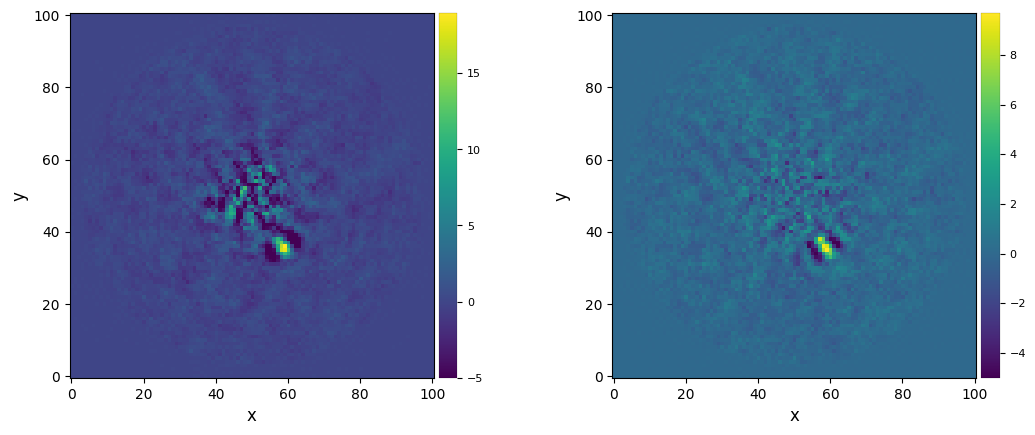

In [40]:
plot_frames((fr_pca_an6, fr_pca_auto), dpi=100, vmin=-5, colorbar=True)

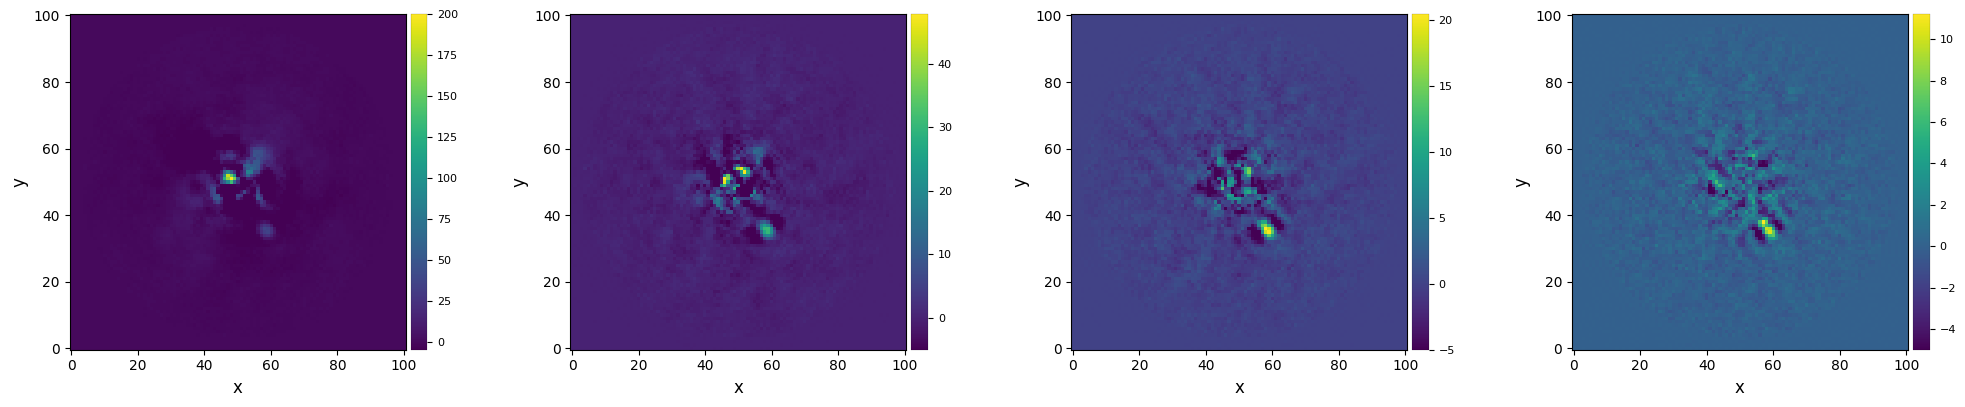

In [41]:
plot_frames(tuple(fr_pca_list), dpi=100, vmin=-5, colorbar=True)

And let's compare the S/N ratio measured in each case: 

In [42]:
snr1 = snr(fr_pca_an6, fwhm=fwhm_naco, source_xy=xy_b, verbose=True)

S/N for the given pixel = 9.094
Integrated flux in FWHM test aperture = 174.531
Mean of background apertures integrated fluxes = -4.528
Std-dev of background apertures integrated fluxes = 19.214


In [43]:
snr2 = snr(fr_pca_auto, fwhm=fwhm_naco, source_xy=xy_b, verbose=True)

S/N for the given pixel = 10.936
Integrated flux in FWHM test aperture = 77.434
Mean of background apertures integrated fluxes = -2.468
Std-dev of background apertures integrated fluxes = 7.130


Despite the relatively high S/N ratio, the planet appears significantly self-subtracted. This is because `delta_rot` was set to a low value. Setting it to a value larger than 0.3 leads to a bug (feel free to test it). This is because for a given image to be modelled, not enough images are found in the rest of the datacube complying with the PA threshold condition for the innermost annuli. To solve this issue, one can increase the radius `radius_int` of the innermost annulus where annular PCA starts. Let's set it to 2 FWHM below:

In [44]:
fr_pca_ann_mask = pca_annular(cube, angs, fwhm=fwhm_naco, ncomp='auto', asize=fwhm_naco, radius_int=2*fwhm_naco,
                              delta_rot=1, nproc=None, svd_mode='lapack', imlib=imlib, 
                              interpolation=interpolation)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-04 12:03:25
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 8, FWHM = 4.801
PCA per annulus (or annular sectors):
Ann 1    PA thresh: 22.62    Ann center:  12    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.072605
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 2    PA thresh: 16.26    Ann center:  17    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.158621
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 3    PA thresh: 12.68    Ann center:  22    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.243790
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 4    PA thresh: 10.39    Ann center:  26    N segments: 1 
Done PCA with lapack for curre

Let's compare previous tests with the new run using an inner mask:

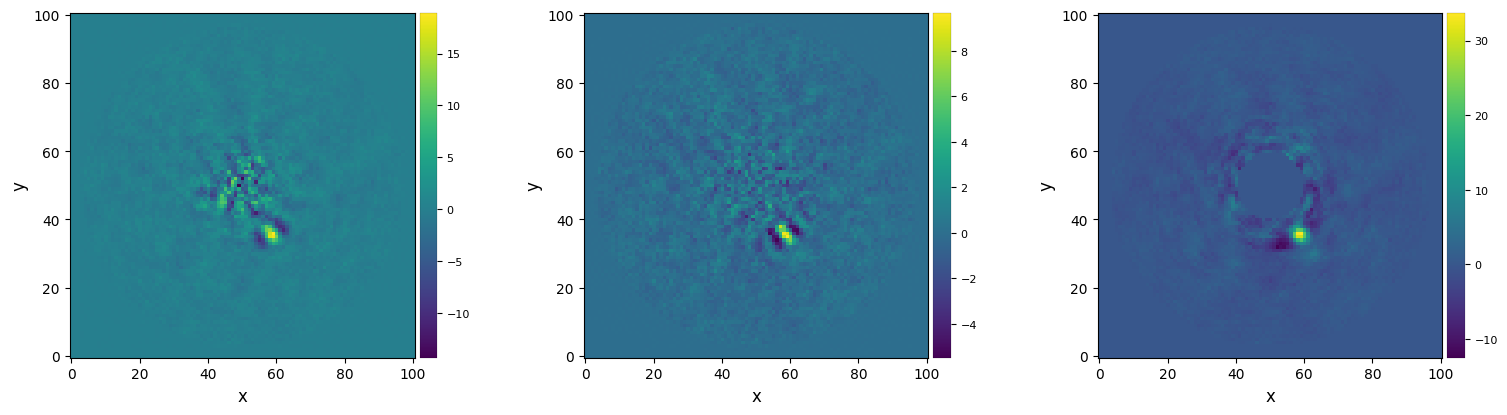

In [45]:
plot_frames((fr_pca_an6, fr_pca_auto, fr_pca_ann_mask))

We notice that much more flux from the planet is now preserved (max intensity > 30 in the third image).

For more flexibility, `delta_rot` can also be set to a tuple of 2 values instead of a scalar. If a tuple, it corresponds to the PA thresholds for the innermost and outermost annuli in the image (linearly interpolated in between).

In [46]:
fr_pca_ddrot = pca_annular(cube, angs, fwhm=fwhm_naco, ncomp='auto', asize=fwhm_naco, delta_rot=(0.2,1), 
                           nproc=None, svd_mode='lapack', imlib=imlib, interpolation=interpolation)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-04 12:03:27
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 10, FWHM = 4.801
PCA per annulus (or annular sectors):
Ann 1    PA thresh: 22.62    Ann center:   2    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.052450
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 2    PA thresh: 11.00    Ann center:   7    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.132942
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 3    PA thresh:  8.64    Ann center:  12    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.249336
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 4    PA thresh:  7.63    Ann center:  17    N segments: 1 
Done PCA with lapack for curr

Let's compare with the image obtained with a single PA threshold at all radii.

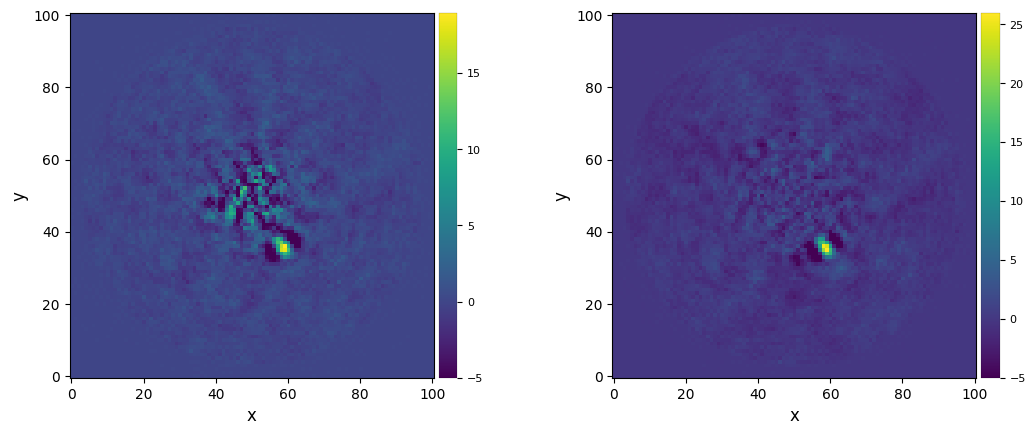

In [47]:
plot_frames((fr_pca_an6, fr_pca_ddrot), dpi=100, vmin=-5, colorbar=True)

The residual speckle noise is now lower in the innermost part of the image.

### 3.5.6. PCA in a single annulus and PCA grid

Once a companion candidate has been identified, the fastest way to recover (and hence characterize) it is to apply PCA on a single annulus encompassing the companion candidate. This is used in particular for the characterization of companion candidates with the negative fake companion technique (see `Tutorial 5. Planet forward modeling`). The relevant function is called `pca_annulus`, which requires the radius `r_guess` of the annulus to be provided, and its `annulus_width`.

In [48]:
from vip_hci.psfsub import pca_annulus
ncomp_test = 5
pca_ann_test = pca_annulus(cube, angs, ncomp=ncomp_test, annulus_width=3*fwhm_naco, r_guess=rad,
                           imlib=imlib, interpolation=interpolation)

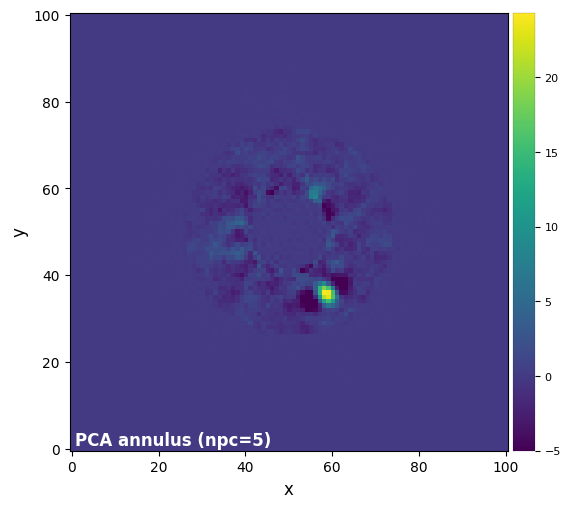

In [49]:
plot_frames(pca_ann_test, label='PCA annulus (npc={:.0f})'.format(ncomp_test),
            dpi=100, vmin=-5, colorbar=True)

Let's now use `pca_grid` to search for the optimal $n_{\rm pc}$ that maximizes the S/N ratio of a given point source. `pca_grid` encompasses both the `pca` and `pca_annulus` function, depending on whether `mode='fullfr'` or `mode='annular'`, respectively. This will allow us to answer Q3.9 we posed earlier: <font color=orange> Is the optimal number of PCs the same for full-frame PCA and PCA in an annulus? </font>

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-04 12:03:32
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.035888
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Number of steps 31
Optimal number of PCs = 13, for S/N=9.093
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Coords of chosen px (X,Y) = 58.5, 35.5
Flux in a centered 1xFWHM circular aperture = 117.483
Central pixel S/N = 11.308
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Inside a centered 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 9.093
Max S/N (shifting the aperture center) = 12.204
stddev S/N (shifting the aperture center) = 1.975

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-04 12:04:53
―――――

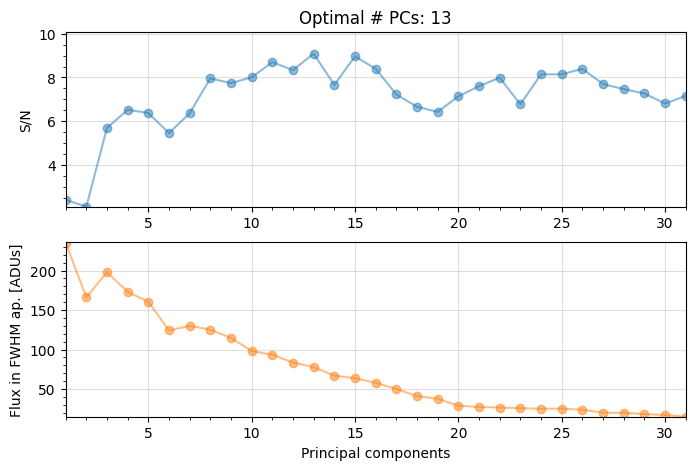

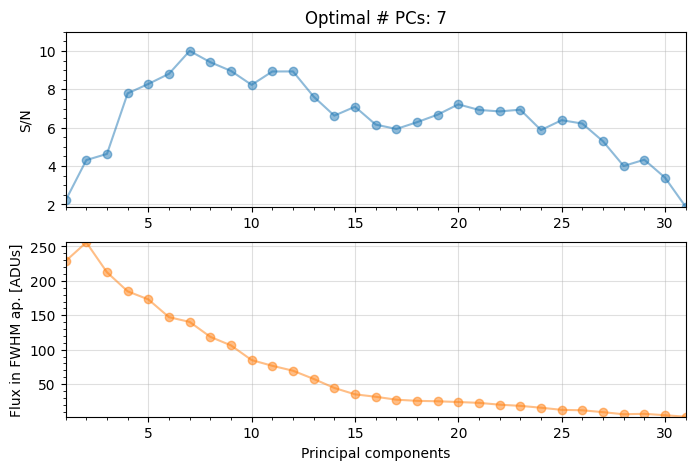

In [50]:
from vip_hci.psfsub import pca_grid
# full frame
res_ff_opt = pca_grid(cube, angs, fwhm=fwhm_naco, range_pcs=(1,31,1), source_xy=xy_b, mode='fullfr', 
                      imlib=imlib, interpolation=interpolation, full_output=True, plot=True)

# single annulus with no PA threshold
res_ann_opt = pca_grid(cube, angs, fwhm=fwhm_naco, range_pcs=(1,31,1), source_xy=xy_b, mode='annular',
                       annulus_width=3*fwhm_naco, imlib=imlib, interpolation=interpolation, 
                       full_output=True, plot=True)

For full-frame PCA the optimal npc is found to be 13 -- as already seen in [Sec. 3.5.2](#3.5.2.-Optimizing-the-number-of-PCs-for-full-frame-PCA-ADI) (the grid mode can indeed be activated automatically with the `pca` function by passing a tuple or list for `ncomp` and specifying `source_xy`)

For PCA on a single annulus, the optimal npc is found to be 7 in the cell above, hence lower.

Let's plot the final images below. Note that since we ran `pca_grid` with the `full_output=True` option, both final images and optimal number of pcs are returned (among other outputs).

In [51]:
_, final_ff_opt, _, opt_npc_ff = res_ff_opt
_, final_ann_opt, _, opt_npc_ann = res_ann_opt

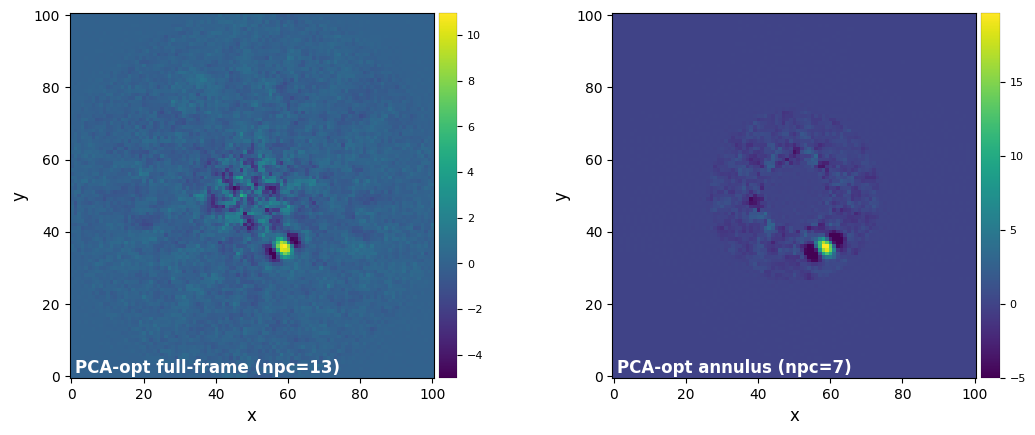

In [52]:
plot_frames((final_ff_opt, final_ann_opt), label=('PCA-opt full-frame (npc={:.0f})'.format(opt_npc_ff), 
                                                  'PCA-opt annulus (npc={:.0f})'.format(opt_npc_ann)),
            dpi=100, vmin=-5, colorbar=True)

<font color='green'> **Answer 5.6**: The optimal $n_{\rm pc}$ is in general lower for PCA on a single annulus than on full frame. Intuitively, one could expect this result due to the smaller number of pixels in the annular case compared to the full frame case. With less pixels (i.e. a smaller matrix for singular value decomposition), a lower $n_{\rm pc}$ is sufficient to achieve similar (or better) modeling of speckle. Conversely a lower $n_{\rm pc}$ would be enough to cause overfitting. </font> 

## 3.6. Non-negative Matrix Factorization (NMF)

A PSF reference can be modelled using a low-rank approximation different than PCA (which relies on singular value decomposition). Non-negative matrix factorization is one such alternative method ([Gomez Gonzalez et al. 2017](https://ui.adsabs.harvard.edu/abs/2017AJ....154....7G/abstract); [Ren et al. 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...852..104R/abstract)). Instead of decomposing $M = U\Sigma V$ (SVD), non-negative matrix factorization aims to decompose $M = \mathcal{W} \mathcal{H}$, where both matrices are non-negative, and the columns of $\mathcal{H}$ are the non-zero components onto which the images are projected (note that the residuals after model subtraction can be negative though).

The two matrices are typically found iteratively. Currently, the default method in VIP is based on the `scikit-learn` implementation of NMF. By default, the principal components obtained by SVD are used as first guess to initiate the iterative process, although the option of using random matrices can also be used. In some cases, the results may look fairly similar to PCA, in particular if the PCs are mostly non-negative.

### 3.6.1. Full-frame NMF

Full-frame NMF is simply done by calling the `nmf` function. Input arguments are mostly similar to `pca`, apart from `init_svd` which sets the method used to estimate the initial SVD from which the solution is iteratively found.

In [53]:
from vip_hci.psfsub import nmf
fr_nmf = nmf(cube, angs, ncomp=14, max_iter=10000, init_svd='nndsvdar', mask_center_px=None, imlib=imlib, 
             interpolation=interpolation)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-04 12:06:15
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running time:  0:00:02.499527
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done NMF with sklearn.NMF.
Running time:  0:00:02.502793
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done derotating and combining.
Running time:  0:00:04.899504
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


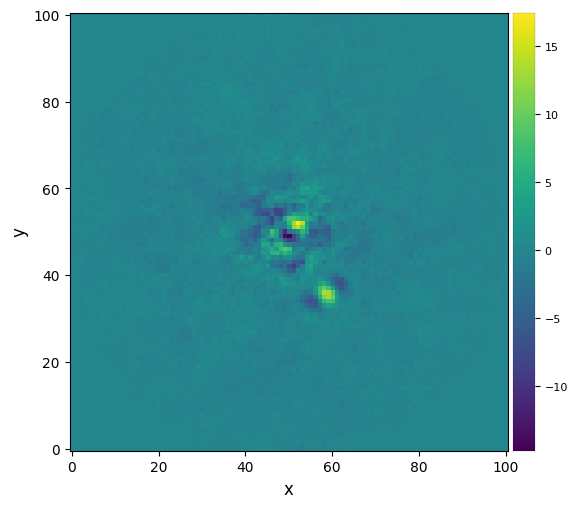

In [54]:
plot_frames(fr_nmf, dpi=100, colorbar=True)#, backend='bokeh')

In [55]:
snr_nmf = snr(fr_nmf, fwhm=fwhm_naco, source_xy=xy_b, verbose=True)

S/N for the given pixel = 8.686
Integrated flux in FWHM test aperture = 135.400
Mean of background apertures integrated fluxes = -8.202
Std-dev of background apertures integrated fluxes = 16.134


### 3.6.2. Annular NMF

The same as above can be performed in concentric annuli (new since v1.0.0):

In [56]:
from vip_hci.psfsub import nmf_annular
fr_nmf_ann = nmf_annular(cube, angs, ncomp=9, max_iter=10000, init_svd='nndsvdar', radius_int=0, nproc=None,
                         fwhm=fwhm_naco, asize=fwhm_naco, imlib=imlib, interpolation=interpolation)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-04 12:06:20
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 10, FWHM = 4.801
NMF per annulus (or annular sectors):
Ann 1    PA thresh: 11.42    Ann center:   2    N segments: 1 
Running time:  0:00:00.354380
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 2    PA thresh:  7.63    Ann center:   7    N segments: 1 
Running time:  0:00:00.964333
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 3    PA thresh:  6.87    Ann center:  12    N segments: 1 
Running time:  0:00:01.847587
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 4    PA thresh:  6.54    Ann center:  17    N segments: 1 
Running time:  0:00:02.726886
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 5    PA thresh:  6.36    Ann center: 

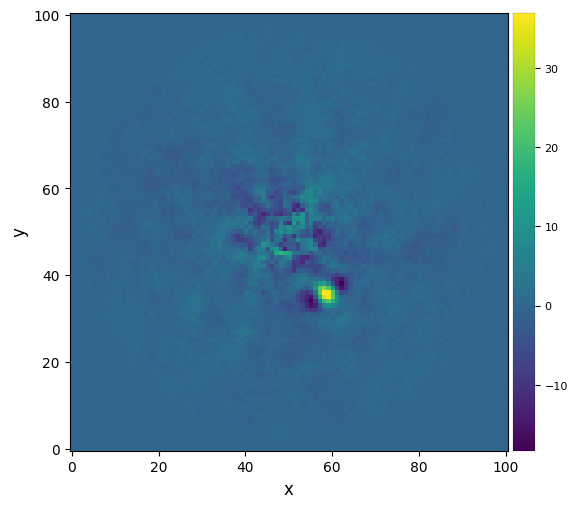

In [57]:
plot_frames(fr_nmf_ann, dpi=100, colorbar=True)

In [58]:
snr_nmf_ann = snr(fr_nmf_ann, fwhm=fwhm_naco, source_xy=xy_b, verbose=True)

S/N for the given pixel = 8.341
Integrated flux in FWHM test aperture = 376.171
Mean of background apertures integrated fluxes = -14.049
Std-dev of background apertures integrated fluxes = 45.656


――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-04 12:06:34
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


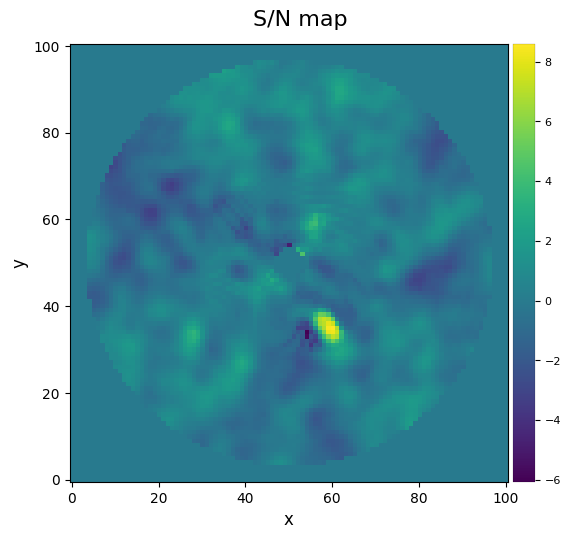

S/N map created using 5 processes
Running time:  0:00:03.229571
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [59]:
snrmap_nmf_ann = snrmap(fr_nmf_ann, fwhm_naco, plot=True)

## 3.7. Local Low-rank plus Sparse plus Gaussian-noise decomposition (LLSG)

Local Low-rank plus Sparse plus Gaussian-noise decomposition (LLSG; [Gomez Gonzalez et al. 2016](https://ui.adsabs.harvard.edu/abs/2016A%26A...589A..54G/abstract)) proposes a three terms decomposition to improve the detectability of point-like sources in ADI data. It aims at decomposing ADI cubes into L+S+G (low-rank, sparse and Gaussian noise) terms. Separating the noise from the S component (where the moving planet should stay) allows us to increase the S/N of potential planets.

Let's try it out:

In [60]:
from vip_hci.psfsub import llsg
fr_llsg = llsg(cube, angs, fwhm_naco, rank=5, thresh=1, max_iter=20, random_seed=10, 
               imlib=imlib, interpolation=interpolation)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-04 12:06:37
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Annuli = 5
Processing annulus: 
1 : in_rad=0, n_segm=4
2 : in_rad=10, n_segm=4
3 : in_rad=20, n_segm=4
4 : in_rad=30, n_segm=4
5 : in_rad=40, n_segm=4

Running time:  0:00:03.570510
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Let's plot it along the full-frame PCA-ADI result, after the optimization of the number of PCs:

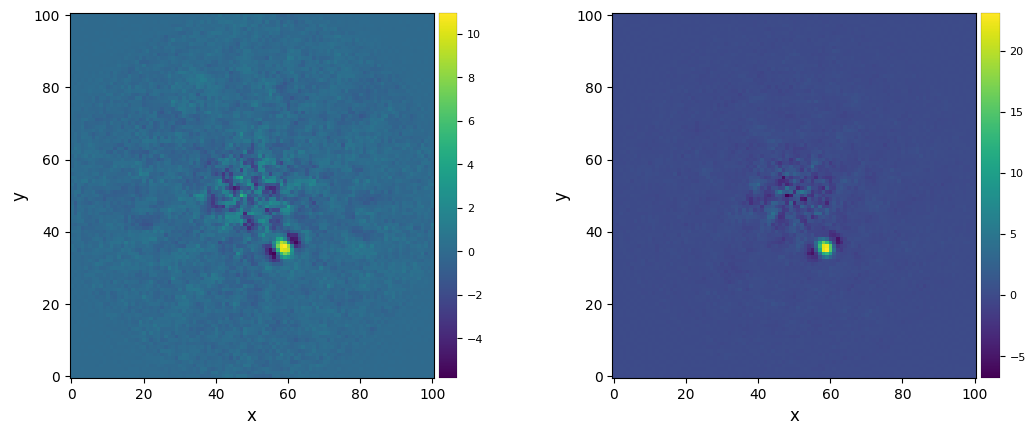

In [61]:
plot_frames((final_ff_opt, fr_llsg))#, backend='bokeh')

The computation of S/N ratio and S/N maps when the noise has been almost totally supressed becomes problematic (both from a theoretical and computational points of view). Let's nevertheless compute them for reference:

In [62]:
snr_llsg = snr(fr_llsg, fwhm=fwhm_naco, source_xy=xy_b, verbose=True)

S/N for the given pixel = 28.461
Integrated flux in FWHM test aperture = 231.948
Mean of background apertures integrated fluxes = -1.765
Std-dev of background apertures integrated fluxes = 8.014


――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-04 12:06:41
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


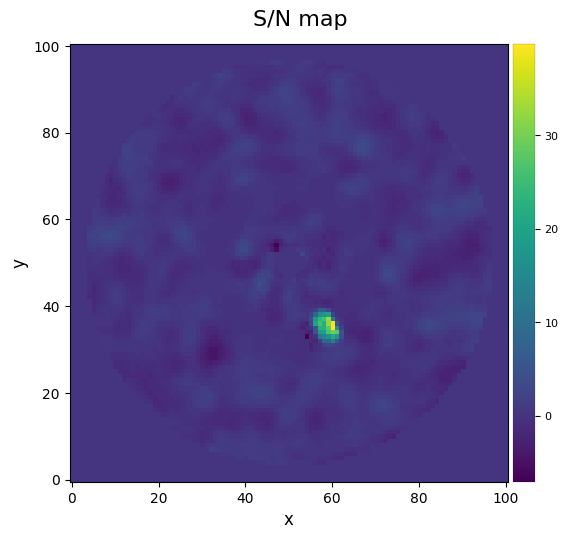

S/N map created using 5 processes
Running time:  0:00:02.961245
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [63]:
snrmap_llsg = snrmap(fr_llsg, fwhm_naco, plot=True)

## 3.8. ANgular Differential OptiMal Exoplanet Detection Algorithm (ANDROMEDA)

Another approach to find point sources in ADI sequences consists in i) subtracting pairs of images separated by a known amount of rotation (typically 0.5 FWHM to produce a specific positive-negative signature); ii) find this residual signature using a maximum match-filter; iii) evaluate the likelihood that a point source is present at each pixel and the corresponding photometry. 
This is what ANDROMEDA does ([Mugnier et al. (2009)](https://ui.adsabs.harvard.edu/abs/2009JOSAA..26.1326M/abstract), [Cantalloube et al. (2015)](https://ui.adsabs.harvard.edu/abs/2015A%26A...582A..89C/abstract)). The principle is summarized in this figure:

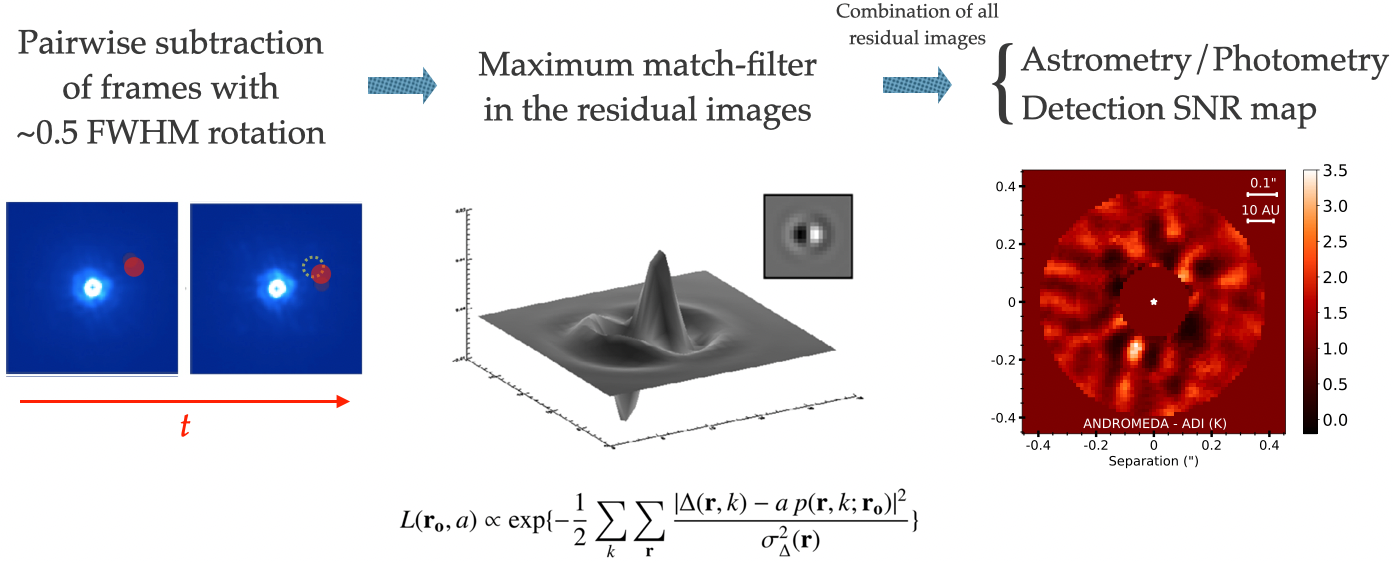

ANDROMEDA follows an inverse-problem approach since it involves a model for the expected positive-negative signature of a point source, and finding the optimal coefficients which minimize residuals between model and observed residual images.

The `andromeda` function in VIP requires the calculation of the oversampling factor (i.e. ratio between Nyquist sampling and actual pixel sampling):

In [64]:
lbda = VLT_NACO['lambdal']
diam = VLT_NACO['diam']
resel = (lbda/diam)*206265 # lambda/D in arcsec
nyquist_samp = resel/2.
oversamp_fac = nyquist_samp/pxscale_naco
oversamp_fac

1.7577458534791308

Let's now try it:

In [65]:
from vip_hci.invprob import andromeda
res = andromeda(cube, oversamp_fac, angs, psf, filtering_fraction=.25,
              min_sep=.5, annuli_width=1., roa=2, opt_method='lsq',
              nsmooth_snr=18, iwa=2, owa=None, precision=50, fast=False, 
              homogeneous_variance=True, ditimg=1.0, ditpsf=None, tnd=1.0,
              total=False, multiply_gamma=True, nproc=1, verbose=False)

In [66]:
flux, snr, snr_norm, stdcontrast, stdcontrast_norm, likelihood, ext_radius = res

One can then plot the SNR and flux of a putative companion at each pixel:

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
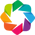

:Layout
   .Image.I  :Image   [x,y]   (z)
   .Image.II :Image   [x,y]   (z)

In [67]:
plot_frames((snr_norm, flux), backend='bokeh')

## 3.9. Forward-Model Matched Filter (FMMF)

Let's now test the forward-model matched filter (FMMF) with both LOCI and KLIP ([Pueyo 2016](https://ui.adsabs.harvard.edu/abs/2016ApJ...824..117P/abstract); [Ruffio et al. 2017](https://ui.adsabs.harvard.edu/abs/2017ApJ...842...14R/abstract); [Dahlqvist et al. 2021](https://ui.adsabs.harvard.edu/abs/2021A%26A...646A..49D/abstract)):

In [68]:
if version.parse(vvip) >= version.parse("1.2.4"):
    from vip_hci.invprob import fmmf
    loci_fmmf_f, loci_fmmf_snr = fmmf(cube, angs, psf, fwhm_naco, model='LOCI', var='FR', nproc=None,
                                      min_r = int(2*fwhm_naco), max_r = int(6*fwhm_naco),
                                      param={'ncomp': 10, 'tolerance': 0.005, 'delta_rot': 0.5},
                                      crop=5, imlib=imlib, interpolation=interpolation)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-04 12:06:48
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Radial distance 9 done!
Radial distance 11 done!
Radial distance 10 done!
Radial distance 12 done!
Radial distance 13 done!
Radial distance 14 done!
Radial distance 15 done!
Radial distance 16 done!
Radial distance 17 done!
Radial distance 18 done!
Radial distance 19 done!
Radial distance 20 done!
Radial distance 21 done!
Radial distance 22 done!
Radial distance 23 done!
Radial distance 24 done!
Radial distance 25 done!
Radial distance 26 done!
Radial distance 27 done!
Running time:  0:23:00.139567
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [69]:
if version.parse(vvip) >= version.parse("1.2.4"):
    klip_fmmf_f, klip_fmmf_snr = fmmf(cube, angs, psf, fwhm_naco, model='KLIP', var='FR', nproc=None,
                                      min_r = int(2*fwhm_naco), max_r = int(6*fwhm_naco),
                                      param={'ncomp': 10, 'tolerance': 0.005, 'delta_rot': 0.5},
                                      crop=5, imlib=imlib, interpolation=interpolation)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-07-04 12:29:48
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Radial distance 9 done!
Radial distance 11 done!
Radial distance 10 done!
Radial distance 12 done!
Radial distance 13 done!
Radial distance 14 done!
Radial distance 15 done!
Radial distance 16 done!
Radial distance 17 done!
Radial distance 18 done!
Radial distance 19 done!
Radial distance 20 done!
Radial distance 21 done!
Radial distance 22 done!
Radial distance 23 done!
Radial distance 24 done!
Radial distance 25 done!
Radial distance 26 done!
Radial distance 27 done!
Running time:  0:16:01.326370
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Radial distance 19 done!
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Int

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Radial distance 21 done!
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Int

Radial distance 22 done!
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Int

Radial distance 23 done!
Radial distance 24 done!
Radial distance 25 done!
Radial distance 26 done!
Radial distance 27 done!
Running time:  1:20:30.163641
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


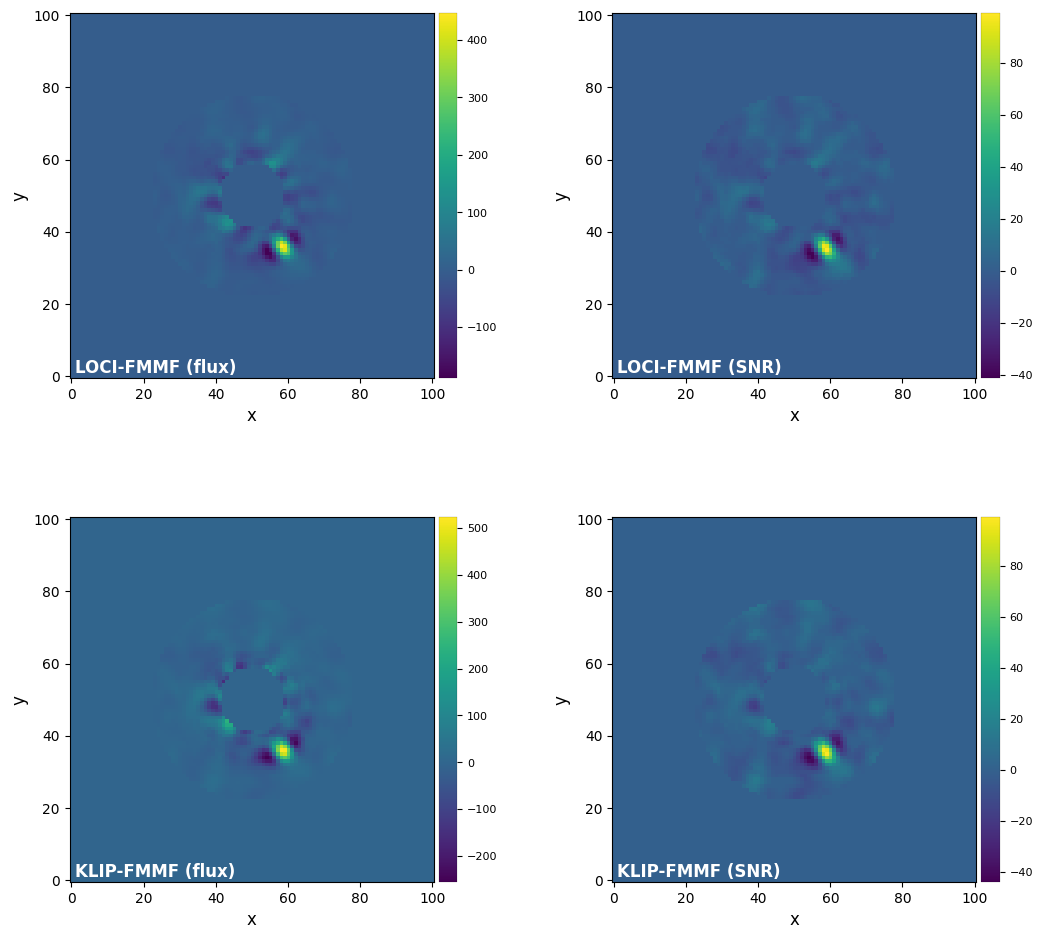

In [70]:
if version.parse(vvip) >= version.parse("1.2.4"):
    plot_frames((loci_fmmf_f, loci_fmmf_snr, klip_fmmf_f, klip_fmmf_snr), rows=2, 
                 label=('LOCI-FMMF (flux)', 'LOCI-FMMF (SNR)','KLIP-FMMF (flux)','KLIP-FMMF (SNR)'))#, backend='bokeh')

## 3.10. Patch Covariances (PACO)

The PAtch COvariances (PACO) algorithm was introduced by [Flasseur et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018A%26A...618A.138F/abstract). It provides a method for extracting the faint signal of the exoplanet from the background noise by building up an empirical model of the background noise. The motion of the planet through the ADI frame is used to identify statistically significant point sources within the field of view. Finally, the flux of the planet can be estimated using an iterative fitting procedure.

Two versions of the PACO algorithm are implemented. While the FullPACO method is more statistically robust, FastPACO produces adequate results in a much shorter time, and has been parallelised using the multiprocessing library.

In [71]:
if version.parse(vvip) >= version.parse("1.2.4"):
    from vip_hci.invprob import FastPACO
    paco = FastPACO(cube=cube, angles=angs, psf = psf, dit_psf = 1.0, dit_science = 1.0, nd_transmission = 1.0,
                    fwhm=pxscale_naco*fwhm_naco,#PACO takes the fwhm in arcsec
                    pixscale = pxscale_naco, rescaling_factor = 1.0, verbose = True)
    paco_snr, paco_flux = paco.run(cpu = cpu_count()//2)

---------------------- 
Summary of PACO setup: 

Image Cube shape = (61, 101, 101)
PIXSCALE = 0.02719
PSF |  Area  |  Rad   |  Width | 
    |   49   |  04    |  039   | 
Patch width: 11
---------------------- 

Precomputing Statistics using 5 Processes...
FWHM: 4.876
Flux in 1xFWHM aperture: 1.338
Running Fast PACO...
Done


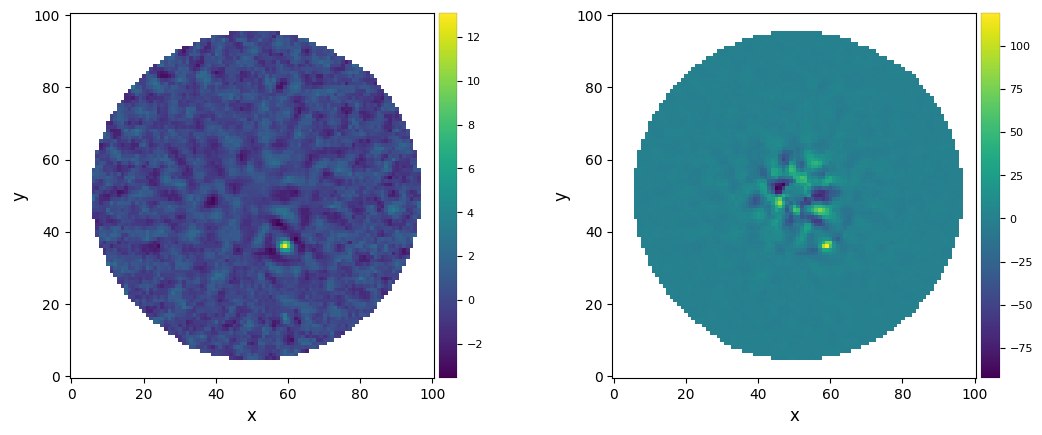

In [72]:
if version.parse(vvip) >= version.parse("1.2.4"):
    plot_frames((paco_snr, paco_flux), label=("PACO SNR", "PACO flux"))

We can now estimate the flux from the snr map.

In [73]:
if version.parse(vvip) >= version.parse("1.2.4"):
    sources = paco.subpixel_threshold_detect(paco_snr, threshold = 5.0, full_output=True) #Threshold in sigma
    posns = [(sources[entry]['x'], sources[entry]['y']) for entry in sources]
    initial_guesses = [paco_flux[int(s[0]),int(s[1])] for s in posns]
    flux_estimates = paco.flux_estimate(posns,eps = 0.1, initial_est = initial_guesses)

Blobs found: 1
 ycen   xcen
------ ------
36.157 	 59.019

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
X,Y = (59.0,36.2)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Coords of chosen px (X,Y) = 59.0, 36.2
Flux in a centered 1xFWHM circular aperture = 76.650
Central pixel S/N = 8.655
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Inside a centered 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 6.520
Max S/N (shifting the aperture center) = 8.338
stddev S/N (shifting the aperture center) = 1.291

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Computing unbiased flux estimate...
Initial guesses:
Positions:  [(59.01921485197563, 36.15707518713191)]
Contrasts:  [2.648086366374206]
FWHM: 4.876
Flux in 1xFWHM aperture: 1.338
Precomputing Statistics...
166.62096836836545
Flux estimate: [143.36293494]
Flux estimate: [136.78680199]
Extr

## 3.11. Summary mosaic

Let's take a look at the final residual frames produced by the different algorithms:

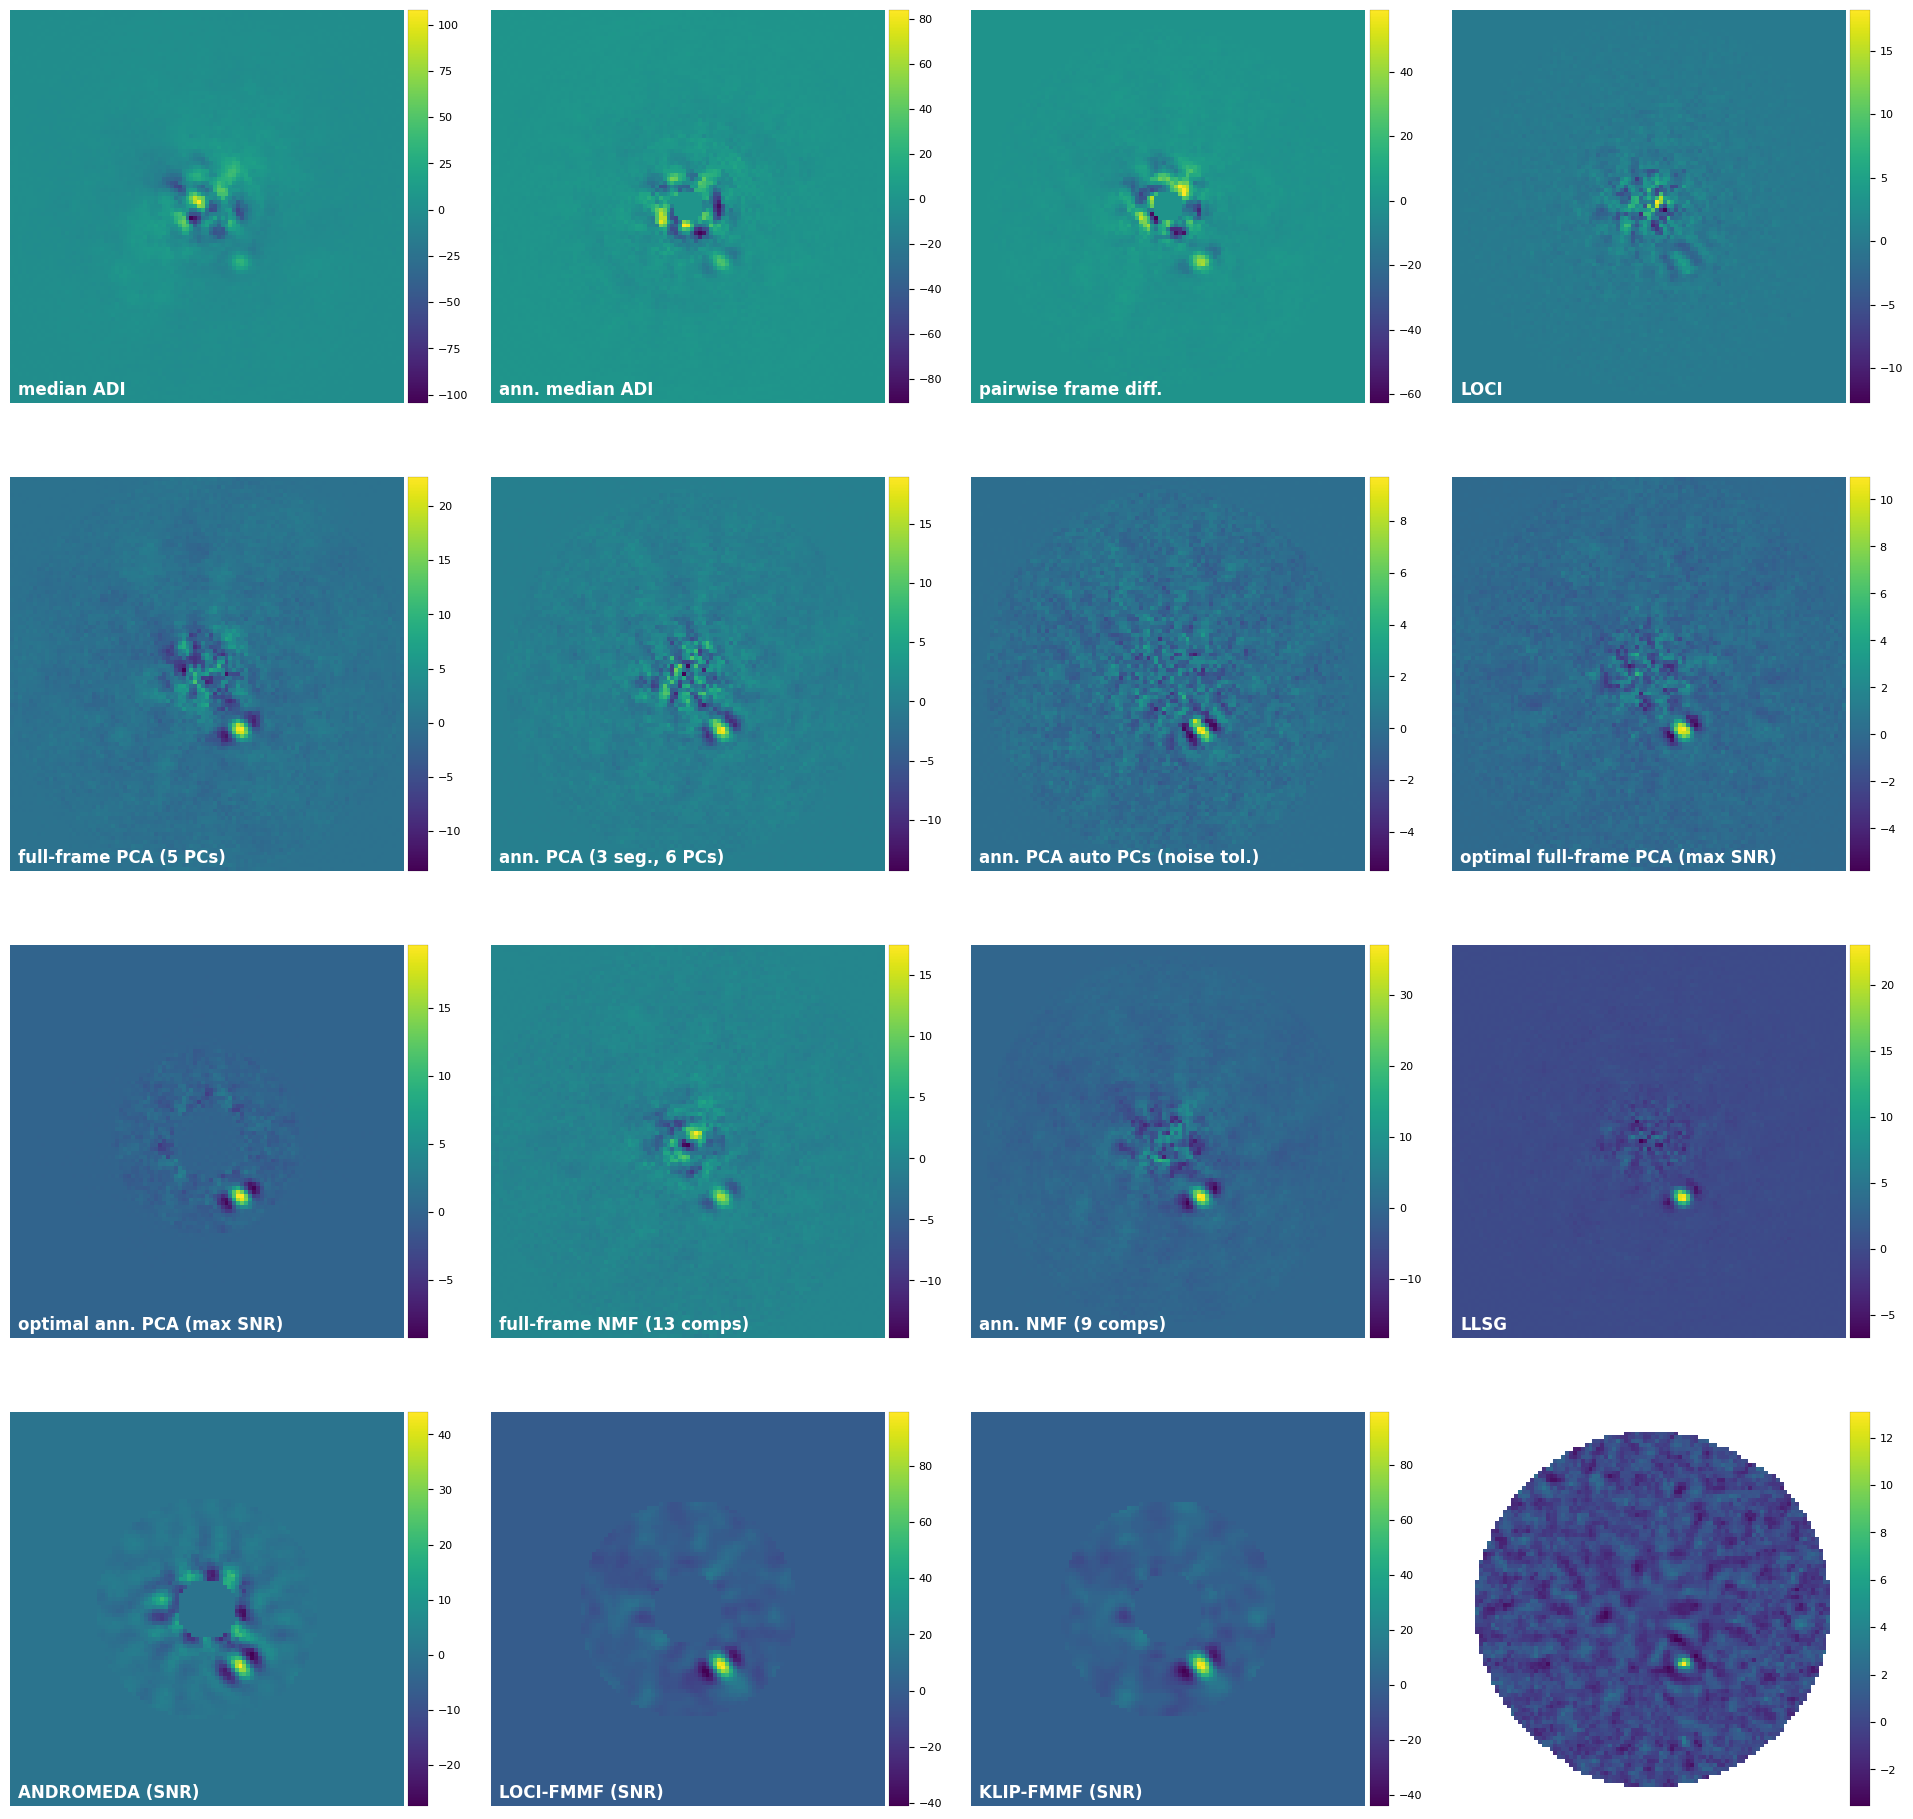

In [74]:
if version.parse(vvip) <= version.parse("1.2.3"):
    plot_frames((fr_adi, fr_adi_an, fr_fdiff, fr_lstsq, fr_pca1, fr_pca_an6, 
                 fr_pca_auto, final_ff_opt, final_ann_opt, fr_nmf, fr_nmf_ann, 
                 fr_llsg, snr_norm), 
                rows=3, colorbar=True, label_size=12, label_pad=8, axis=False, versp=0.05, horsp=0.15, 
                label=('median ADI', 'ann. median ADI', 'pairwise frame diff.', 'LOCI', 
                       'full-frame PCA (5 PCs)', 'ann. PCA (3 seg., 6 PCs)', 
                       'ann. PCA auto PCs (noise tol.)', 'optimal full-frame PCA (max SNR)', 
                       'optimal ann. PCA (max SNR)', 'full-frame NMF (13 comps)', 'ann. NMF (9 comps)',
                       'LLSG', 'ANDROMEDA (SNR)'))
else:
    plot_frames((fr_adi, fr_adi_an, fr_fdiff, fr_lstsq, fr_pca1, fr_pca_an6, 
                 fr_pca_auto, final_ff_opt, final_ann_opt, fr_nmf, fr_nmf_ann, 
                 fr_llsg, snr_norm, loci_fmmf_snr, klip_fmmf_snr, paco_snr), 
                rows=4, colorbar=True, label_size=12, label_pad=8, axis=False, versp=0.05, horsp=0.15, 
                label=('median ADI', 'ann. median ADI', 'pairwise frame diff.', 'LOCI', 
                       'full-frame PCA (5 PCs)', 'ann. PCA (3 seg., 6 PCs)', 
                       'ann. PCA auto PCs (noise tol.)', 'optimal full-frame PCA (max SNR)', 
                       'optimal ann. PCA (max SNR)', 'full-frame NMF (13 comps)', 'ann. NMF (9 comps)',
                       'LLSG', 'ANDROMEDA (SNR)', 'LOCI-FMMF (SNR)', 'KLIP-FMMF (SNR)', 'PACO (SNR)'))

Check out tutorial `4. Metrics` for more details on evaluating i) the significance of a potential point source, ii) the achieved contrast in your image, in the form of contrast curves.